# Model Assessment

### Project Goal  : build a model predicting  `pa_approved` based on the following features<br>
- `bin`  The BIN of the payer(insurance company) for the claim.
- `drug`   The drug that was associated with the claim.
- `reject_code`   If the claim was rejected, what was the associated rejection code. It tells you the reason why the claim has been rejected.
- `correct_diagnosis`    Flag for information provided by the provider indicating that the patient has the correct diagnosis for the associated drug.
- `tried_and_failed`    Flag for information provided by the provider indicating that the patient has tried and failed the relevant generic alternatives.
- `contraindication`    Flag for information provided by the provider indicating that the patient has an associated contraindication for the medication requested.

### Summary of what have been done in the previous notebooks
- We concluded that the feature `reject_code` is redundant and dropped from our model.
- We noticed that there were some nontrivial interaction between features and added the interaction terms of the pairs (`bin`, `drug`), (`tried_and_faild`,`drug`),(`contraindication`,`drug`). 
- Using cross validation, we selected features and tuned hyperparameters.
- We chose <i>'Logistic Regression'</i> as our machine learning model.

### Summary of this notebook
- Although we chose <i>logistic regression</i> as our machine learning model, we will also see how well other models(<i>decision tree</i>, <i>xgboost</i>) generalize to the test data.
- We will calculate key performance indicators of the models using the test data.
- We will calculate the bias-variance decompositions of the models.
- We will calculate the confidance intervals of the key performance indicators using bootstrapping method.

## 0. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score,recall_score, f1_score, roc_auc_score, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
cl =pd.read_csv('data/dim_claims.csv')
pa = pd.read_csv('data/dim_pa.csv')
bridge = pd.read_csv('data/bridge.csv')

In [3]:
# merge data
claim = bridge.merge(cl.copy(), how = 'inner', on = 'dim_claim_id')
claim = claim.dropna()
claim = claim.merge(pa.copy(), how = 'inner', on = 'dim_pa_id')
claim = claim.drop(['dim_claim_id','dim_pa_id','dim_date_id','pharmacy_claim_approved'], axis = 1)

In [4]:
# one hot encoding of categorical variable 'bin'
for i in pd.get_dummies(claim.bin).columns :
    claim.loc[:,i] = pd.get_dummies(claim.bin).loc[:, i].copy()

# one hot encoding of categorical variable 'drug'
for i in pd.get_dummies(claim.drug).columns :
    claim.loc[:,i] = pd.get_dummies(claim.drug).loc[:, i].copy()
    
claim = claim.drop(['bin', 'drug'], axis = 1)

In [5]:
y = claim.loc[:, 'pa_approved']
X = claim.drop(['pa_approved','reject_code'], axis =1)

In [6]:
X.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C'],
      dtype='object')

In [7]:
# interaction of the variables 'bin' and 'drug'
for i in X.columns[3:7] :
    for j in X.columns[7:10] : 
        X.loc[:,str(i)+j] = X.loc[:,i] * X.loc[:,j]

In [8]:
X.head()

,correct_diagnosis,tried_and_failed,contraindication,417380,417614,417740,999001,A,B,C,...,417380C,417614A,417614B,417614C,417740A,417740B,417740C,999001A,999001B,999001C
0,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: pa_approved, dtype: int64

In [10]:
# data split => train : test = 4:1
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                    shuffle = True,
                                                    random_state = 623,
                                                    test_size = .2,
                                                    stratify = y.copy())

## 1. Feature Selection and  Hyperparameter Tuning

In [11]:
# tuned hyperparameters
paras = pd.DataFrame(data = {'accuracy_score' : [{},{},{}],
                             'precision' : [{},{},{}],
                             'true_positive_rate' : [{},{},{}],
                             'false_positive_rate' : [{},{},{}],
                             'f1' : [{},{},{}],
                             'roc_auc' : [{},{},{}]},
                     index=['Log','DT','XGB'])

In [12]:
paras

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,{},{},{},{},{},{}
DT,{},{},{},{},{},{}
XGB,{},{},{},{},{},{}


In [13]:
# kfold object
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 623)

### -Logistic regression-

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
# hyperparameters
Cs = [.01, .1, 1, 10, 100]
penalties = ['none', 'l1','l2','elasticnet']

# cross validation key performance indicators
acses = np.zeros((5, len(Cs),len(penalties)))
pres = np.zeros((5, len(Cs),len(penalties)))
tprs = np.zeros((5, len(Cs),len(penalties)))
fprs = np.zeros((5, len(Cs),len(penalties)))
f1s = np.zeros((5, len(Cs),len(penalties)))
aucs = np.zeros((5, len(Cs),len(penalties)))

In [16]:
# hyperparameter tuning via cross validation
i=0
for train_index, test_index in kfold.split(X_train, y_train) :
    j=0
    # loop through various regularization constants
    for C in Cs :
        # loop through various penalty norms
        k=0
        for penalty in penalties :
            X_tt = X_train.iloc[train_index, :].copy()
            X_ho = X_train.iloc[test_index, :].copy()
            y_tt = y_train.iloc[train_index].copy()
            y_ho = y_train.iloc[test_index].copy()
            
            if penalty == 'l1' :
                log_reg = LogisticRegression(penalty = penalty, C=C, solver = 'liblinear', max_iter = 100)
            elif penalty == 'elasticnet' :
                log_reg = LogisticRegression(penalty = penalty, C=C, solver = 'saga', max_iter = 100, l1_ratio = .5)
            else:
                log_reg = LogisticRegression(penalty = penalty, C=C, max_iter = 100)
                
            log_reg.fit(X_tt.values, y_tt.values)
            pred = log_reg.predict(X_ho.values)
            pred_proba = log_reg.predict_proba(X_ho.values)[:, 1]
            
            acses[i,j,k] = accuracy_score(y_ho.values, pred)
            conf_mat = confusion_matrix(y_ho, pred)
            pres[i,j,k] = precision_score(y_ho, pred)
            tprs[i,j,k] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
            fprs[i,j,k] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
            f1s[i,j,k] = f1_score(y_ho, pred)
            aucs[i,j,k] = roc_auc_score(y_ho, pred_proba)
            k=k+1
        j=j+1      
    i=i+1

In [17]:
# tuned hyperparameters

# accuracy_score
cv = np.mean(acses, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'accuracy_score']['penalty'] = penalties[penalty_index]
paras.loc['Log', 'accuracy_score']['C'] = Cs[C_index]

# precision
cv = np.mean(aucs, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'precision']['penalty'] =  penalties[penalty_index]
paras.loc['Log', 'precision']['C'] = Cs[C_index]

# true positive rate
cv = np.mean(aucs, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'true_positive_rate']['penalty'] =  penalties[penalty_index]
paras.loc['Log', 'true_positive_rate']['C'] = Cs[C_index]

# false positive rate
cv = np.mean(aucs, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'false_positive_rate']['penalty'] =  penalties[penalty_index]
paras.loc['Log', 'false_positive_rate']['C'] = Cs[C_index]

# f1_score
cv = np.mean(aucs, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'f1']['penalty'] =  penalties[penalty_index]
paras.loc['Log', 'f1']['C'] = Cs[C_index]

# roc_auc_score
cv = np.mean(aucs, axis = 0)
cv_max = np.max(np.max(cv, axis = 0),axis = 0)
penalty_index = np.argwhere(cv == cv_max)[0][1]
C_index = np.argwhere(cv == cv_max)[0][0]
paras.loc['Log', 'roc_auc']['penalty'] =  penalties[penalty_index]
paras.loc['Log', 'roc_auc']['C'] = Cs[C_index]

In [18]:
paras

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,"{'penalty': 'none', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}"
DT,{},{},{},{},{},{}
XGB,{},{},{},{},{},{}


### -Decision Tree-

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
dt= DecisionTreeClassifier()
# hyperparameters
path = dt.cost_complexity_pruning_path(X_train,y_train)
alphas = np.append(path.ccp_alphas[:5],path.ccp_alphas[-5:])
max_depths = np.linspace(1, 32, 32, endpoint=True)
# cross validation key performance indicators
acses = np.zeros((5,len(max_depths), len(alphas)))
pres = np.zeros((5,len(max_depths), len(alphas)))
tprs = np.zeros((5,len(max_depths), len(alphas)))
fprs = np.zeros((5,len(max_depths), len(alphas)))
f1s = np.zeros((5,len(max_depths), len(alphas)))
aucs = np.zeros((5,len(max_depths), len(alphas)))

In [21]:
# hyperparameter tuning via cross validation
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index, :10].copy()
    X_ho = X_train.iloc[test_index, :10].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    # loop through various max_depths
    j=0
    for max_depth in max_depths :
        k=0
        for ccp_alpha in alphas :
            dt = DecisionTreeClassifier(max_depth = max_depth)
            dt.fit(X_tt.values, y_tt.values)
            pred = dt.predict(X_ho.values)
            pred_proba = dt.predict_proba(X_ho.values)[:,1]
            
            acses[i,j,k] = accuracy_score(y_ho.values, pred)
            conf_mat = confusion_matrix(y_ho, pred)
            pres[i,j,k] = precision_score(y_ho, pred)
            tprs[i,j,k] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
            fprs[i,j,k] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
            f1s[i,j,k] = f1_score(y_ho, pred)
            aucs[i,j,k] = roc_auc_score(y_ho, pred_proba)
            k=k+1
        j=j+1
    i=i+1

In [22]:
# tuned hyperparameters

# accuracy_score
cv = np.mean(acses, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'accuracy_score']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'accuracy_score']['ccp_alpha'] = alphas[alpha_index]

# precision
cv = np.mean(pres, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'precision']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'precision']['ccp_alpha'] = alphas[alpha_index]

# true_positive_rate
cv = np.mean(tprs, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'true_positive_rate']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'true_positive_rate']['ccp_alpha'] = alphas[alpha_index]

# false_positive_rate
cv = np.mean(fprs, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'false_positive_rate']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'false_positive_rate']['ccp_alpha'] = alphas[alpha_index]

# f1
cv = np.mean(f1s, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'f1']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'f1']['ccp_alpha'] = alphas[alpha_index]

# roc_auc
cv = np.mean(aucs, axis = 0)
max_cv = np.max(cv, axis = 0)
depth_index = np.argwhere(cv == max_cv)[0][0]
alpha_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['DT', 'roc_auc']['max_depth'] = max_depths[depth_index]
paras.loc['DT', 'roc_auc']['ccp_alpha'] = alphas[alpha_index]

In [23]:
paras

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,"{'penalty': 'none', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}"
DT,"{'max_depth': 8.0, 'ccp_alpha': 0.0}","{'max_depth': 7.0, 'ccp_alpha': 0.0}","{'max_depth': 1.0, 'ccp_alpha': 0.0}","{'max_depth': 1.0, 'ccp_alpha': 0.0}","{'max_depth': 8.0, 'ccp_alpha': 0.0}","{'max_depth': 8.0, 'ccp_alpha': 0.0}"
XGB,{},{},{},{},{},{}


### -XGBoost-

In [24]:
from xgboost import XGBClassifier

In [25]:
# hyperparameters
learning_rates = [0.01, 0.1, 1, 10, 100]
max_depths = [3, 5, 10]
# cross validation key performance indicators
acses = np.zeros((5,len(learning_rates), len(max_depths)))
pres = np.zeros((5,len(learning_rates), len(max_depths)))
tprs = np.zeros((5,len(learning_rates), len(max_depths)))
fprs = np.zeros((5,len(learning_rates), len(max_depths)))
f1s = np.zeros((5,len(learning_rates), len(max_depths)))
aucs = np.zeros((5,len(learning_rates), len(max_depths)))

In [26]:
# hyperparameter tuning via cross validation
i=0
for train_index, test_index in kfold.split(X_train, y_train) : 
    X_tt = X_train.iloc[train_index, :10].copy()
    X_ho = X_train.iloc[test_index, :10].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    # loop through various learning rates
    j=0
    for learning_rate in learning_rates :
        # loop through various max_depths
        k=0
        for max_depth in max_depths :
            xgb = XGBClassifier(learning_rate = learning_rate,
                                    max_depth = max_depth,
                                    use_label_encoder=False,
                                    n_estimators = 100,
                                    random_state = 623,
                                    eval_metric = 'logloss')
            xgb.fit(X_tt.values, y_tt.values,
                    early_stopping_rounds = 3,
                    eval_set = [(X_ho.values, y_ho.values)])
            pred = xgb.predict(X_ho.values)
            pred_proba = xgb.predict_proba(X_ho.values)[:,1]
            
            acses[i,j,k] = accuracy_score(y_ho.values, pred)
            conf_mat = confusion_matrix(y_ho, pred)
            pres[i,j,k] = precision_score(y_ho, pred)
            tprs[i,j,k] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
            fprs[i,j,k] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
            f1s[i,j,k] = f1_score(y_ho, pred)
            aucs[i,j,k] = roc_auc_score(y_ho, pred_proba)
            k=k+1
        j=j+1
    i=i+1        

[0]	validation_0-logloss:0.68993
[1]	validation_0-logloss:0.68677
[2]	validation_0-logloss:0.68366
[3]	validation_0-logloss:0.68066
[4]	validation_0-logloss:0.67759
[5]	validation_0-logloss:0.67465
[6]	validation_0-logloss:0.67175
[7]	validation_0-logloss:0.66900
[8]	validation_0-logloss:0.66618
[9]	validation_0-logloss:0.66352
[10]	validation_0-logloss:0.66089
[11]	validation_0-logloss:0.65828
[12]	validation_0-logloss:0.65567
[13]	validation_0-logloss:0.65314
[14]	validation_0-logloss:0.65074
[15]	validation_0-logloss:0.64834
[16]	validation_0-logloss:0.64588
[17]	validation_0-logloss:0.64355
[18]	validation_0-logloss:0.64135
[19]	validation_0-logloss:0.63905
[20]	validation_0-logloss:0.63684
[21]	validation_0-logloss:0.63471
[22]	validation_0-logloss:0.63258
[23]	validation_0-logloss:0.63040
[24]	validation_0-logloss:0.62835
[25]	validation_0-logloss:0.62630
[26]	validation_0-logloss:0.62439
[27]	validation_0-logloss:0.62242
[28]	validation_0-logloss:0.62051
[29]	validation_0-loglos

In [27]:
# tuned hyperparameters with respect to the score functions

# accuracy_score
cv = np.mean(acses, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'accuracy_score']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'accuracy_score']['max_depth'] = max_depths[depth_index]

# precision
cv = np.mean(pres, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'precision']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'precision']['max_depth'] = max_depths[depth_index]

# true_positive_rate
cv = np.mean(tprs, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'true_positive_rate']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'true_positive_rate']['max_depth'] = max_depths[depth_index]

# false_positive_rate
cv = np.mean(fprs, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'false_positive_rate']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'false_positive_rate']['max_depth'] = max_depths[depth_index]

# f1
cv = np.mean(f1s, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'f1']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'f1']['max_depth'] = max_depths[depth_index]

# roc_auc
cv = np.mean(aucs, axis = 0)
max_cv = np.max(np.max(cv, axis = 0),axis = 0)
rate_index = np.argwhere(cv == max_cv)[0][0]
depth_index = np.argwhere(cv == max_cv)[0][1]
paras.loc['XGB', 'roc_auc']['learning_rate'] = learning_rates[rate_index]
paras.loc['XGB', 'roc_auc']['max_depth'] = max_depths[depth_index]

In [28]:
paras

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,"{'penalty': 'none', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.01}"
DT,"{'max_depth': 8.0, 'ccp_alpha': 0.0}","{'max_depth': 7.0, 'ccp_alpha': 0.0}","{'max_depth': 1.0, 'ccp_alpha': 0.0}","{'max_depth': 1.0, 'ccp_alpha': 0.0}","{'max_depth': 8.0, 'ccp_alpha': 0.0}","{'max_depth': 8.0, 'ccp_alpha': 0.0}"
XGB,"{'learning_rate': 0.1, 'max_depth': 5}","{'learning_rate': 1, 'max_depth': 3}","{'learning_rate': 0.01, 'max_depth': 3}","{'learning_rate': 0.01, 'max_depth': 3}","{'learning_rate': 0.1, 'max_depth': 3}","{'learning_rate': 1, 'max_depth': 5}"


## 2. Model Evaluation

In [29]:
# key performance indicators
kpis = pd.DataFrame(data = {'accuracy_score' : np.zeros(3),
                            'precision' : np.zeros(3),
                            'true_positive_rate' : np.zeros(3),
                            'false_positive_rate' : np.zeros(3),
                            'f1' : np.zeros(3),
                            'roc_auc' : np.zeros(3)},
                    index=['Log', 'DT', 'XGB'])

In [30]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.0,0.0,0.0,0.0,0.0,0.0
DT,0.0,0.0,0.0,0.0,0.0,0.0
XGB,0.0,0.0,0.0,0.0,0.0,0.0


### -Logistic Regression-

In [31]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)

In [32]:
# computing key performance indicators via cross validation
i=0
for train_index, test_index in kfold.split(X_train, y_train) :
    X_tt = X_train.iloc[train_index, :].copy()
    X_ho = X_train.iloc[test_index, :].copy()
    y_tt = y_train.iloc[train_index].copy()
    y_ho = y_train.iloc[test_index].copy()
    
    
    # accuracy_score
    log_reg = LogisticRegression(penalty = paras.loc['Log','accuracy_score']['penalty'], 
                                 C=paras.loc['Log','accuracy_score']['C'],   
                                 max_iter = 100)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho.values, pred)
    
    # precision
    log_reg = LogisticRegression(penalty = paras.loc['Log','precision']['penalty'], 
                                 C=paras.loc['Log','precision']['C'],
                                 max_iter = 100)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    pres[i] = precision_score(y_ho, pred)
    
    # true_positive_rate
    log_reg = LogisticRegression(penalty = paras.loc['Log','true_positive_rate']['penalty'], 
                                 C=paras.loc['Log','true_positive_rate']['C'],
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    # false_positive_rate
    log_reg = LogisticRegression(penalty = paras.loc['Log','false_positive_rate']['penalty'], 
                                 C=paras.loc['Log','false_positive_rate']['C'],
                                 max_iter = 100, 
                                 l1_ratio = .5)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    # f1
    log_reg = LogisticRegression(penalty = paras.loc['Log','f1']['penalty'], 
                                 C=paras.loc['Log','f1']['C'],
                                 max_iter = 100)
    log_reg.fit(X_tt.values, y_tt.values)
    pred = log_reg.predict(X_ho.values)
    f1s[i] = f1_score(y_ho, pred)
    
    # roc_auc
    log_reg = LogisticRegression(penalty = paras.loc['Log','roc_auc']['penalty'], 
                                 C=paras.loc['Log','roc_auc']['C'], 
                                 max_iter = 100)
    log_reg.fit(X_tt.values, y_tt.values)
    pred_proba = log_reg.predict_proba(X_ho.values)[:,1]
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    i=i+1        

In [33]:
# key performance indicators
kpis.loc['Log','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['Log','precision'] = round(np.mean(pres),3)
kpis.loc['Log','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['Log','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['Log','f1'] = round(np.mean(f1s),3)
kpis.loc['Log','roc_auc'] = round(np.mean(aucs),3)

In [34]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.814,0.834,0.932,0.512,0.88,0.878
DT,0.000,0.000,0.000,0.000,0.00,0.000
XGB,0.000,0.000,0.000,0.000,0.00,0.000


### -Decision Tree-

In [35]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)
# importance scores
acs_importance = np.zeros(10)
pre_importance = np.zeros(10)
tpr_importance = np.zeros(10)
fpr_importance = np.zeros(10)
f1_importance = np.zeros(10)
auc_importance = np.zeros(10)

In [36]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_test, y_test) : 
    X_tt = X_test.iloc[train_index, :10].copy()
    X_ho = X_test.iloc[test_index, :10].copy()
    y_tt = y_test.iloc[train_index].copy()
    y_ho = y_test.iloc[test_index].copy()
    
    # accuracy_score
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','accuracy_score']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho, pred)
    acs_importance = acs_importance + dt.feature_importances_
    
    # precision
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','precision']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    pres[i] = precision_score(y_ho, pred)
    pre_importance = pre_importance + dt.feature_importances_
    
    # true_positive_rate
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','true_positive_rate']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    tpr_importance = tpr_importance + dt.feature_importances_
    
    # false_positive_rate
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','false_positive_rate']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    fpr_importance = fpr_importance + dt.feature_importances_
    
    # f1
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','f1']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred = dt.predict(X_ho.values)
    f1s[i] = f1_score(y_ho, pred)
    f1_importance =f1_importance + dt.feature_importances_
    
    # roc_auc
    dt = DecisionTreeClassifier(max_depth = paras.loc['DT','roc_auc']['max_depth'])
    dt.fit(X_tt.values, y_tt.values)
    pred_proba = dt.predict_proba(X_ho.values)[:,1]
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    auc_importance = auc_importance + dt.feature_importances_
    i=i+1

In [37]:
X_test.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C',           '417380A',           '417380B',
                 '417380C',           '417614A',           '417614B',
                 '417614C',           '417740A',           '417740B',
                 '417740C',           '999001A',           '999001B',
                 '999001C'],
      dtype='object')

-accuracy_score feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
417380 : 0.201
417614 : 0.093
417740 : 0.078
999001 : 0.041
A : 0.182
B : 0.161
C : 0.055


double click the image to zoom in and out


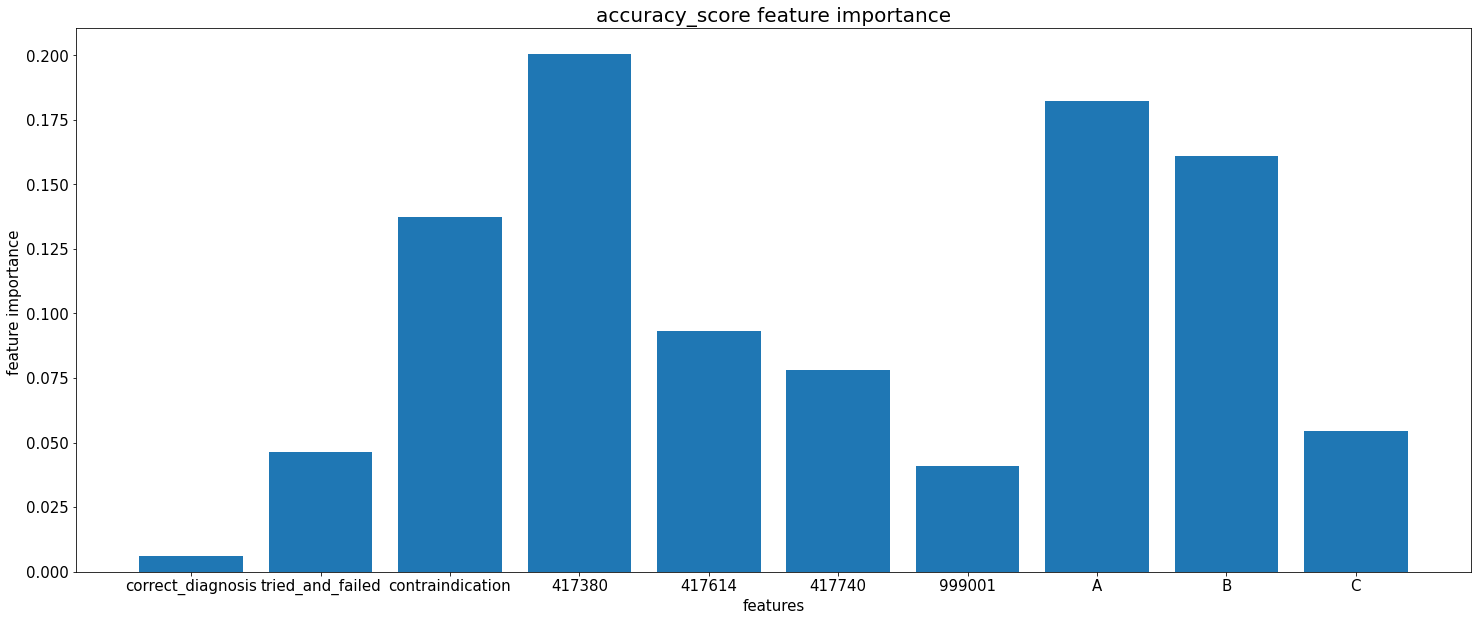



-precision feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.046
contraindication : 0.138
417380 : 0.203
417614 : 0.112
417740 : 0.058
999001 : 0.041
A : 0.063
B : 0.198
C : 0.138


double click the image to zoom in and out


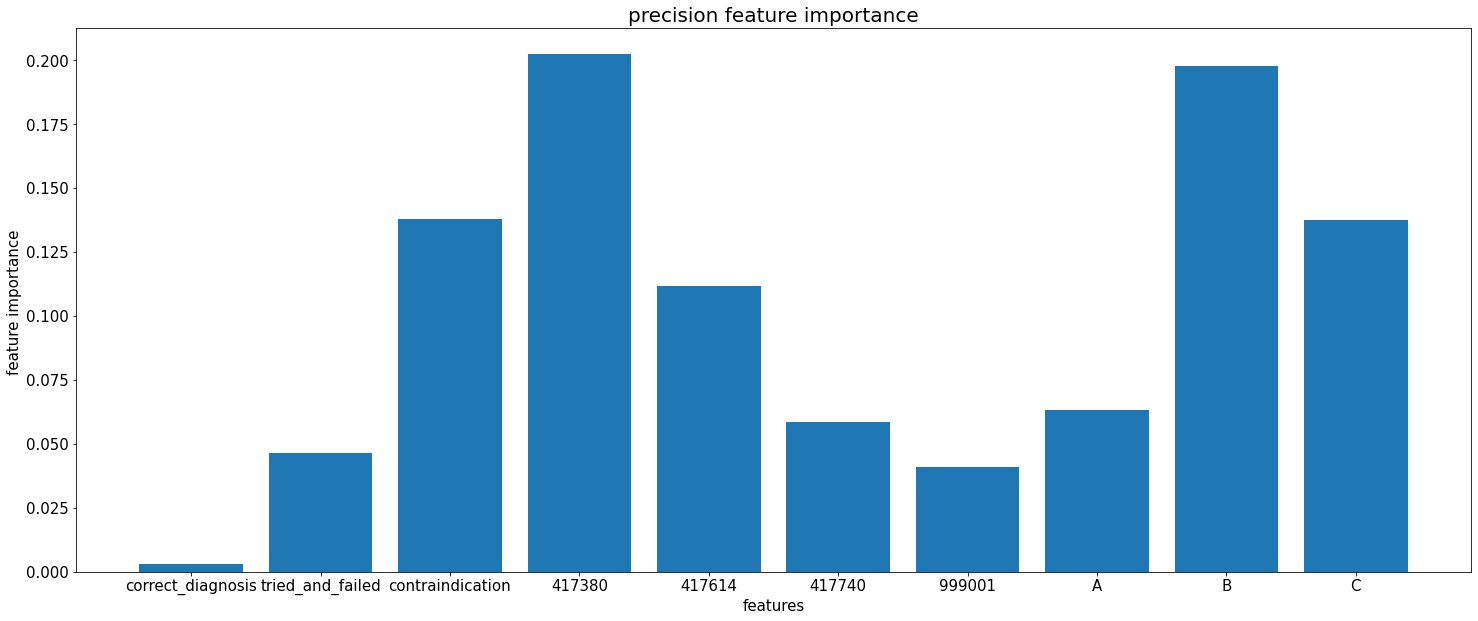



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
417380 : 0.0
417614 : 0.0
417740 : 0.0
999001 : 0.0
A : 0.0
B : 0.0
C : 0.0


double click the image to zoom in and out


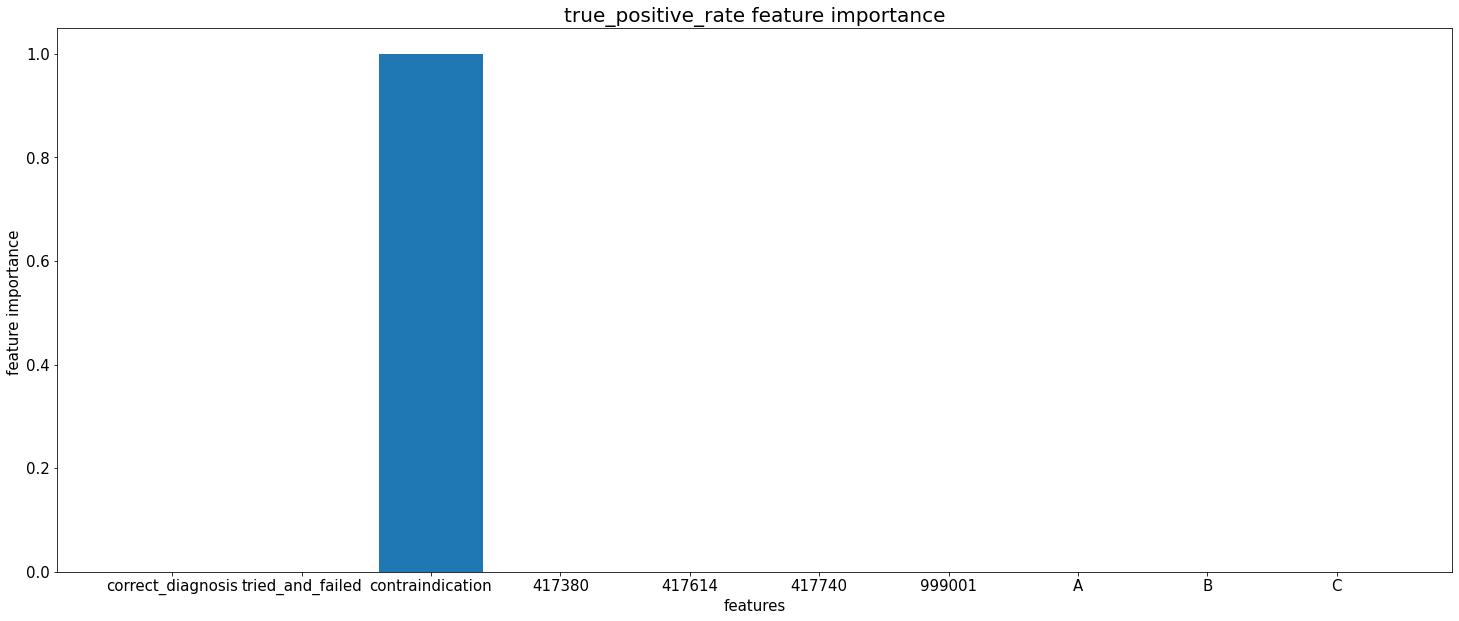



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
417380 : 0.0
417614 : 0.0
417740 : 0.0
999001 : 0.0
A : 0.0
B : 0.0
C : 0.0


double click the image to zoom in and out


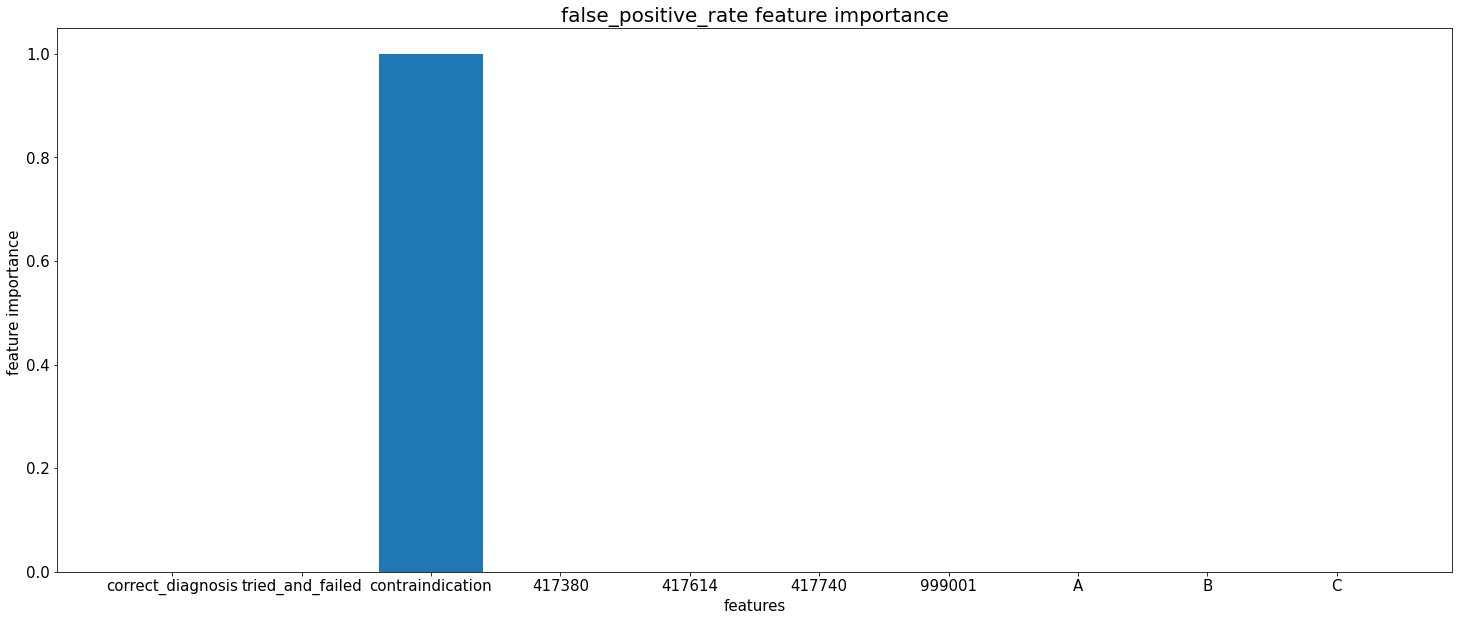



-f1 feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
417380 : 0.194
417614 : 0.11
417740 : 0.065
999001 : 0.044
A : 0.137
B : 0.165
C : 0.096


double click the image to zoom in and out


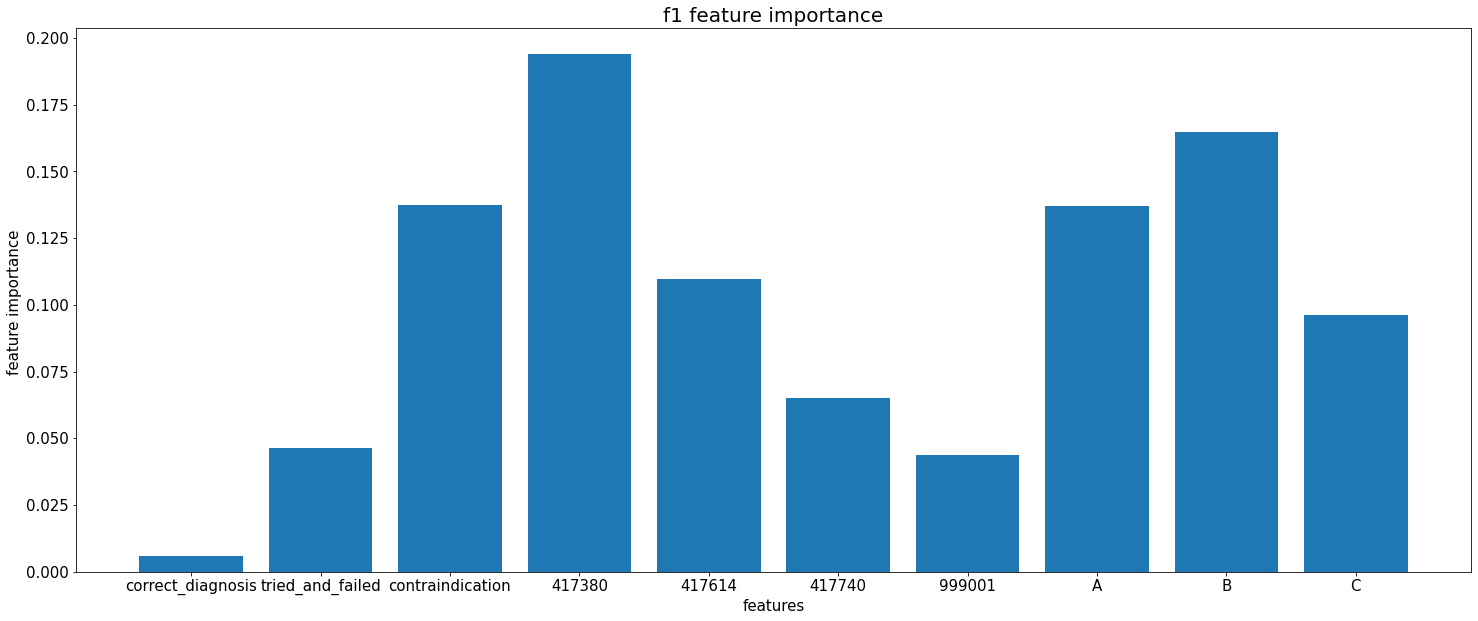



-roc_auc feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
417380 : 0.196
417614 : 0.102
417740 : 0.072
999001 : 0.042
A : 0.099
B : 0.182
C : 0.116


double click the image to zoom in and out


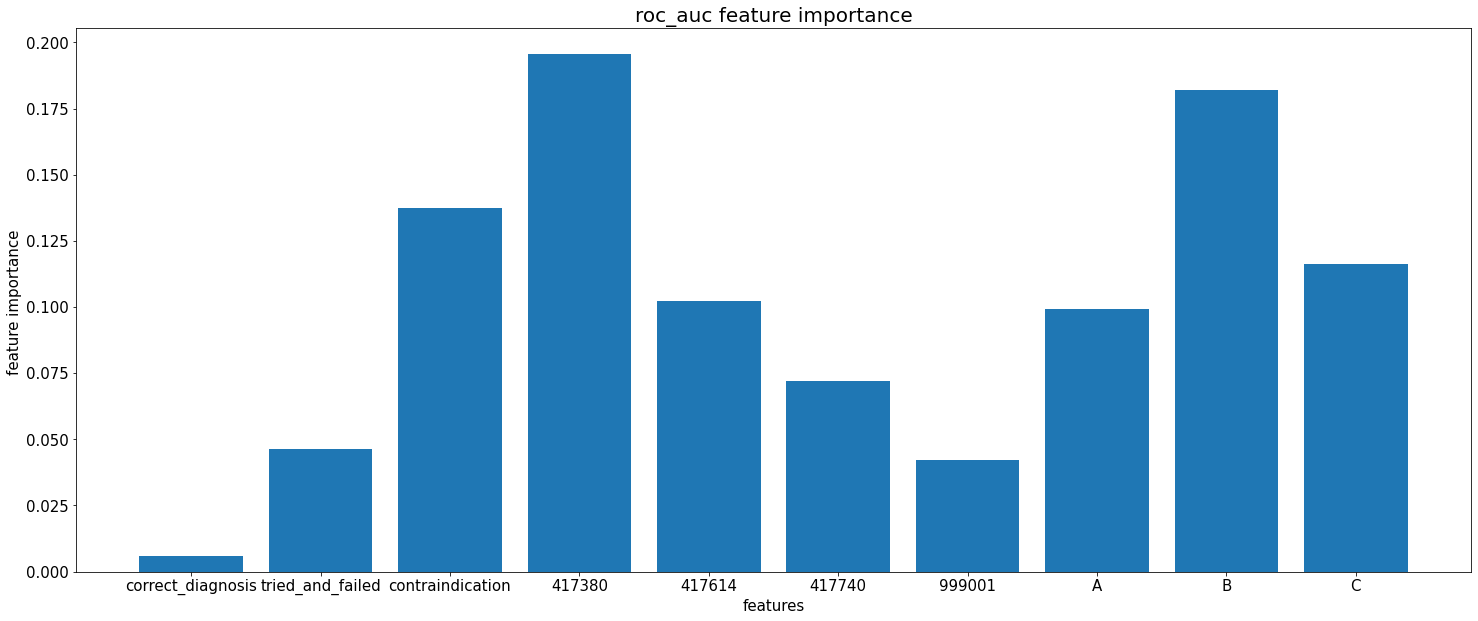

In [38]:
# summarize accuracy_score feature importance
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(X_test.columns[i],':',round(acs_importance[i]/5,3))
# plot accuracy_score feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), acs_importance/5)
plt.show()  


print()
print()


# summarize precision feature importance
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(X_test.columns[i],':',round(pre_importance[i]/5,3))
# plot precision feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), pre_importance/5)
plt.show()    


print()
print()


# summarize true_positive_rate feature importance    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(X_test.columns[i],':',round(tpr_importance[i]/5,3))
# plot true_positive_rate feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), tpr_importance/5)
plt.show()    


print()
print()


# summarize false_positive_rate feature importance 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(X_test.columns[i],':',round(fpr_importance[i]/5,3))
# plot false_positive_rate feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), fpr_importance/5)
plt.show()    


print()
print()


# summarize f1 feature importance   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(X_test.columns[i],':',round(f1_importance[i]/5,3))
# plot f1 feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), f1_importance/5)
plt.show()    


print()
print()


# summarize roc_auc feature importance
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(X_test.columns[i],':',round(auc_importance[i]/5,3))
# plot roc_auc feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), auc_importance/5)
plt.show()  

In [39]:
X_train.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C',           '417380A',           '417380B',
                 '417380C',           '417614A',           '417614B',
                 '417614C',           '417740A',           '417740B',
                 '417740C',           '999001A',           '999001B',
                 '999001C'],
      dtype='object')

In [40]:
# accuracy_score
acs_importance[3] = max(acs_importance[3:7])
acs_importance[4] = max(acs_importance[7:])
acs_importance = acs_importance[:5]
# precision
pre_importance[3] = max(pre_importance[3:7])
pre_importance[4] = max(pre_importance[7:])
pre_importance = pre_importance[:5]
# true_positive_rate
tpr_importance[3] = max(tpr_importance[3:7])
tpr_importance[4] = max(tpr_importance[7:])
tpr_importance = tpr_importance[:5]
# false_positive_rate
fpr_importance[3] = max(fpr_importance[3:7])
fpr_importance[4] = max(fpr_importance[7:])
fpr_importance = fpr_importance[:5]
# f1
f1_importance[3] = max(f1_importance[3:7])
f1_importance[4] = max(f1_importance[7:])
f1_importance = f1_importance[:5]
# roc_auc
auc_importance[3] = max(auc_importance[3:7])
auc_importance[4] = max(auc_importance[7:])
auc_importance = auc_importance[:5]

In [41]:
features = list(X_train.columns.copy())
features[3] = 'bin'
features[4] = 'drug'
features = features[:5]
features

['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin', 'drug']

-accuracy_score feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
bin : 0.201
drug : 0.182


double click the image to zoom in and out


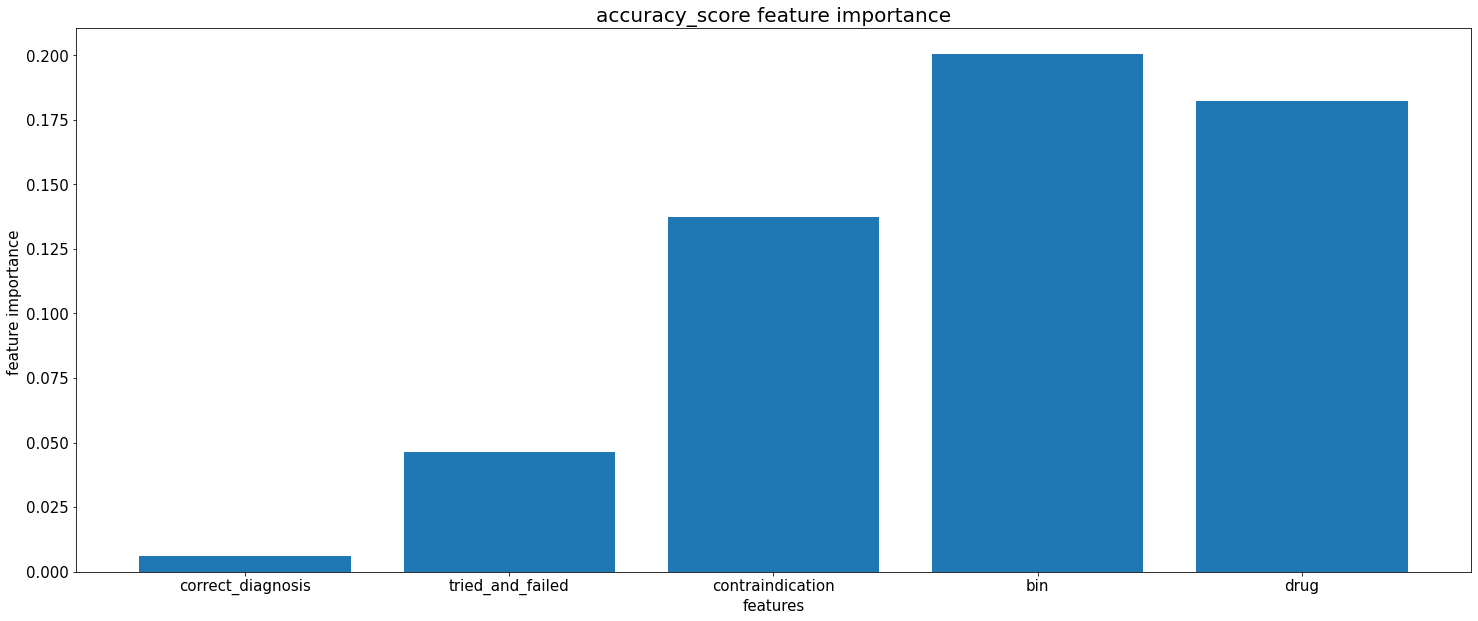



-precision feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.046
contraindication : 0.138
bin : 0.203
drug : 0.198


double click the image to zoom in and out


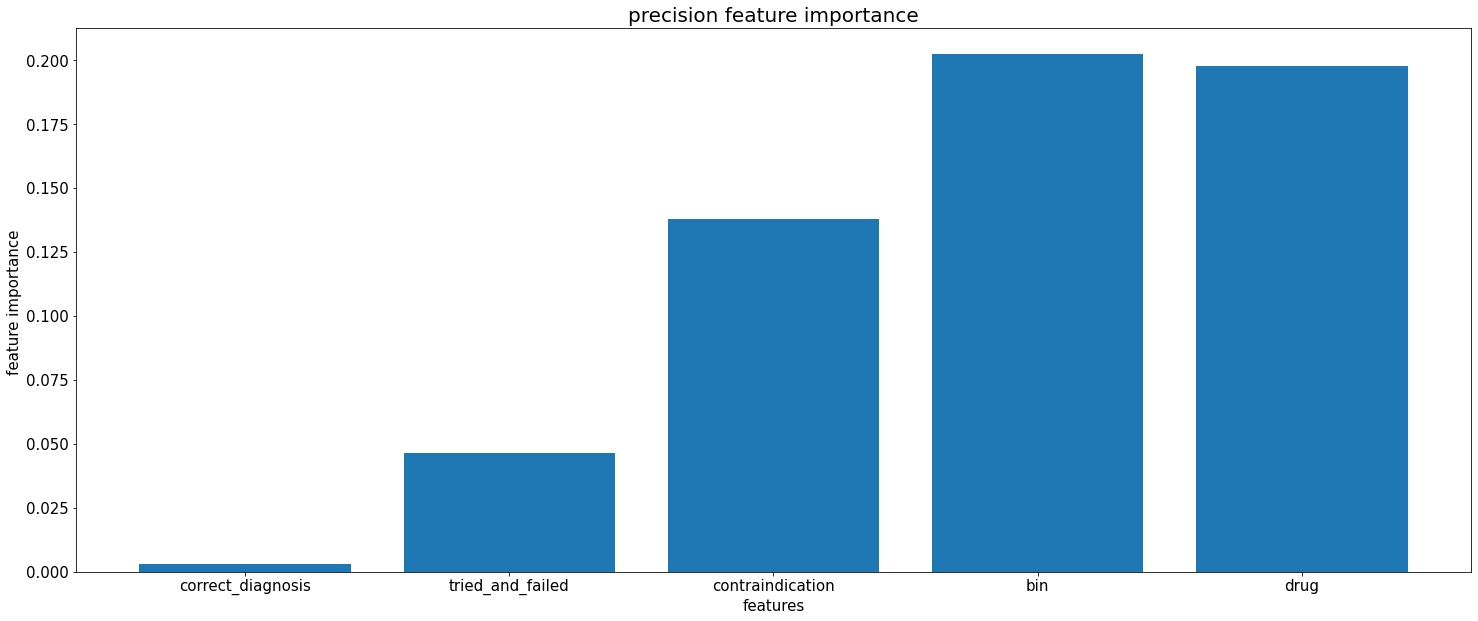



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
bin : 0.0
drug : 0.0


double click the image to zoom in and out


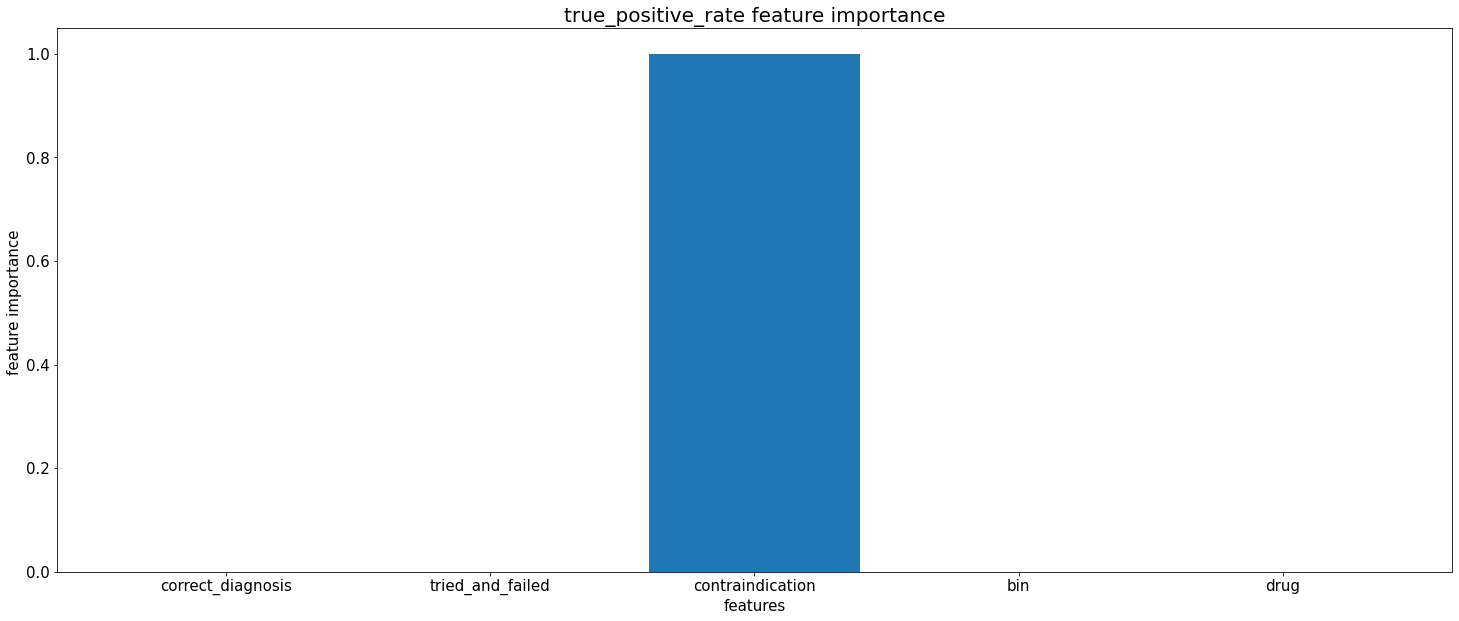



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.0
contraindication : 1.0
bin : 0.0
drug : 0.0


double click the image to zoom in and out


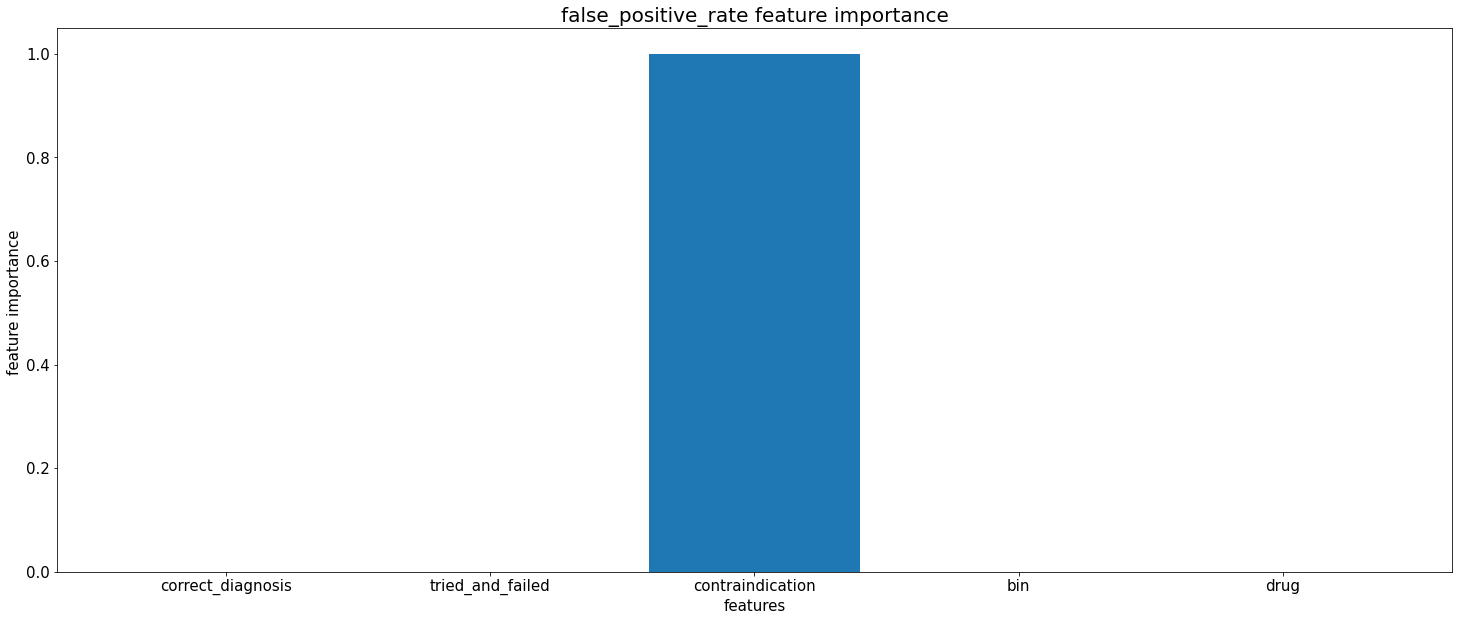



-f1 feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
bin : 0.194
drug : 0.165


double click the image to zoom in and out


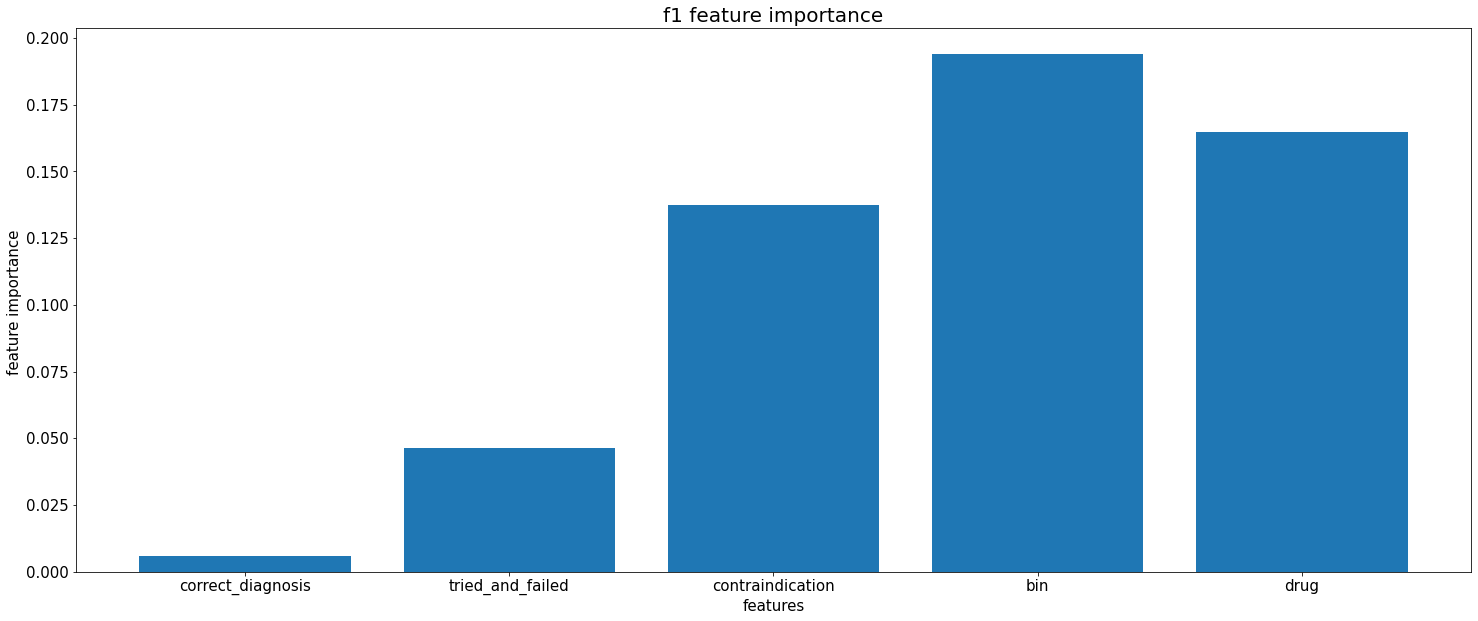



-roc_auc feature importance-

correct_diagnosis : 0.006
tried_and_failed : 0.046
contraindication : 0.137
bin : 0.196
drug : 0.182


double click the image to zoom in and out


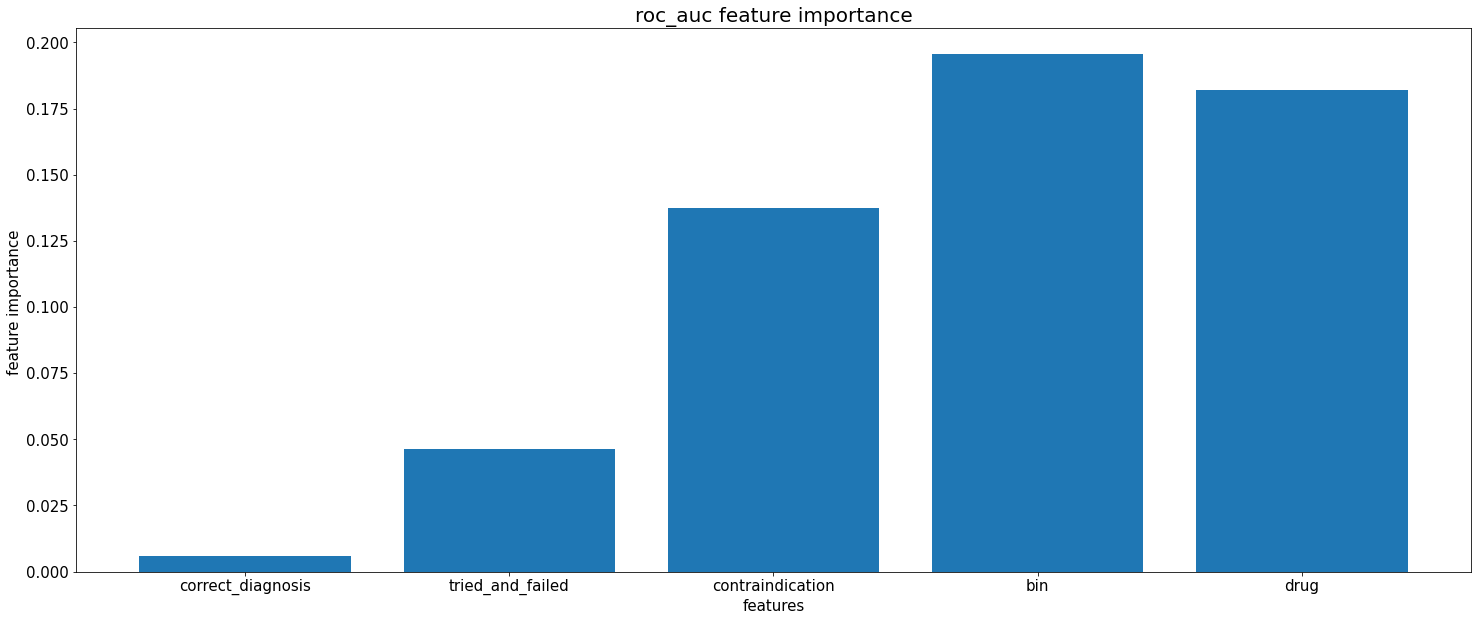

In [42]:
#summarize feature importances with respect to the accuracy_score feature
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(features[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(features, acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision feature
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(features[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(features, pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(features[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(features, tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(features[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(features, fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(features[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(features, f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(features[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(features, auc_importance/5)
plt.show()

In [43]:
# key performance indicators
kpis.loc['DT','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['DT','precision'] = round(np.mean(pres),3)
kpis.loc['DT','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['DT','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['DT','f1'] = round(np.mean(f1s),3)
kpis.loc['DT','roc_auc'] = round(np.mean(aucs),3)

In [44]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.814,0.834,0.932,0.512,0.880,0.878
DT,0.814,0.834,1.000,1.000,0.881,0.878
XGB,0.000,0.000,0.000,0.000,0.000,0.000


### -XGBoost-

In [45]:
# cross validation key performance indicators
acses = np.zeros(5)
pres = np.zeros(5)
tprs = np.zeros(5)
fprs = np.zeros(5)
f1s = np.zeros(5)
aucs = np.zeros(5)
# feature importances
acs_importance = np.zeros(10)
pre_importance = np.zeros(10)
tpr_importance = np.zeros(10)
fpr_importance = np.zeros(10)
f1_importance = np.zeros(10)
auc_importance = np.zeros(10)

In [46]:
# cross validation computing key performance indicators
i=0
for train_index, test_index in kfold.split(X_test, y_test) : 
    X_tt = X_test.iloc[train_index, :10].copy()
    X_ho = X_test.iloc[test_index, :10].copy()
    y_tt = y_test.iloc[train_index].copy()
    y_ho = y_test.iloc[test_index].copy()
    
    # accuracy_score
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','accuracy_score']['learning_rate'],
                    max_depth = paras.loc['XGB','accuracy_score']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)
    acses[i] = accuracy_score(y_ho, pred)
    acs_importance = acs_importance + xgb.feature_importances_
    
    # precision
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','precision']['learning_rate'],
                    max_depth = paras.loc['XGB','precision']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)        
    pres[i] = precision_score(y_ho, pred)
    pre_importance = pre_importance + xgb.feature_importances_
    
    # true_positive_rate
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','true_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','true_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)         
    conf_mat = confusion_matrix(y_ho, pred)
    tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1]) 
    tpr_importance = tpr_importance + xgb.feature_importances_
    
    # false_positive_rate
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','false_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','false_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)
    conf_mat = confusion_matrix(y_ho, pred)
    fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    fpr_importance = fpr_importance + xgb.feature_importances_
    
    # f1
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','f1']['learning_rate'],
                    max_depth = paras.loc['XGB','f1']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred = xgb.predict(X_ho.values)         
    f1s[i] = f1_score(y_ho, pred)
    f1_importance = f1_importance + xgb.feature_importances_
    
    # roc_auc
    xgb = XGBClassifier(learning_rate = paras.loc['XGB','roc_auc']['learning_rate'],
                    max_depth = paras.loc['XGB','roc_auc']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')
    xgb.fit(X_tt.values, y_tt.values,
            early_stopping_rounds = 3,
            eval_set = [(X_ho.values, y_ho.values)])
    pred_proba = xgb.predict_proba(X_ho.values)[:,1]         
    aucs[i] = roc_auc_score(y_ho, pred_proba)
    auc_importance = auc_importance + xgb.feature_importances_
    i=i+1

[0]	validation_0-logloss:0.65097
[1]	validation_0-logloss:0.61654
[2]	validation_0-logloss:0.58753
[3]	validation_0-logloss:0.56302
[4]	validation_0-logloss:0.54194
[5]	validation_0-logloss:0.52416
[6]	validation_0-logloss:0.50864
[7]	validation_0-logloss:0.49495
[8]	validation_0-logloss:0.48011
[9]	validation_0-logloss:0.47005
[10]	validation_0-logloss:0.45962
[11]	validation_0-logloss:0.45021
[12]	validation_0-logloss:0.44203
[13]	validation_0-logloss:0.43609
[14]	validation_0-logloss:0.42964
[15]	validation_0-logloss:0.42517
[16]	validation_0-logloss:0.41876
[17]	validation_0-logloss:0.41319
[18]	validation_0-logloss:0.40859
[19]	validation_0-logloss:0.40427
[20]	validation_0-logloss:0.40051
[21]	validation_0-logloss:0.39739
[22]	validation_0-logloss:0.39556
[23]	validation_0-logloss:0.39284
[24]	validation_0-logloss:0.39148
[25]	validation_0-logloss:0.38927
[26]	validation_0-logloss:0.38795
[27]	validation_0-logloss:0.38687
[28]	validation_0-logloss:0.38522
[29]	validation_0-loglos

In [47]:
X_test.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C',           '417380A',           '417380B',
                 '417380C',           '417614A',           '417614B',
                 '417614C',           '417740A',           '417740B',
                 '417740C',           '999001A',           '999001B',
                 '999001C'],
      dtype='object')

-accuracy_score feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.029
contraindication : 0.117
417380 : 0.14
417614 : 0.121
417740 : 0.056
999001 : 0.076
A : 0.102
B : 0.213
C : 0.141


double click the image to zoom in and out


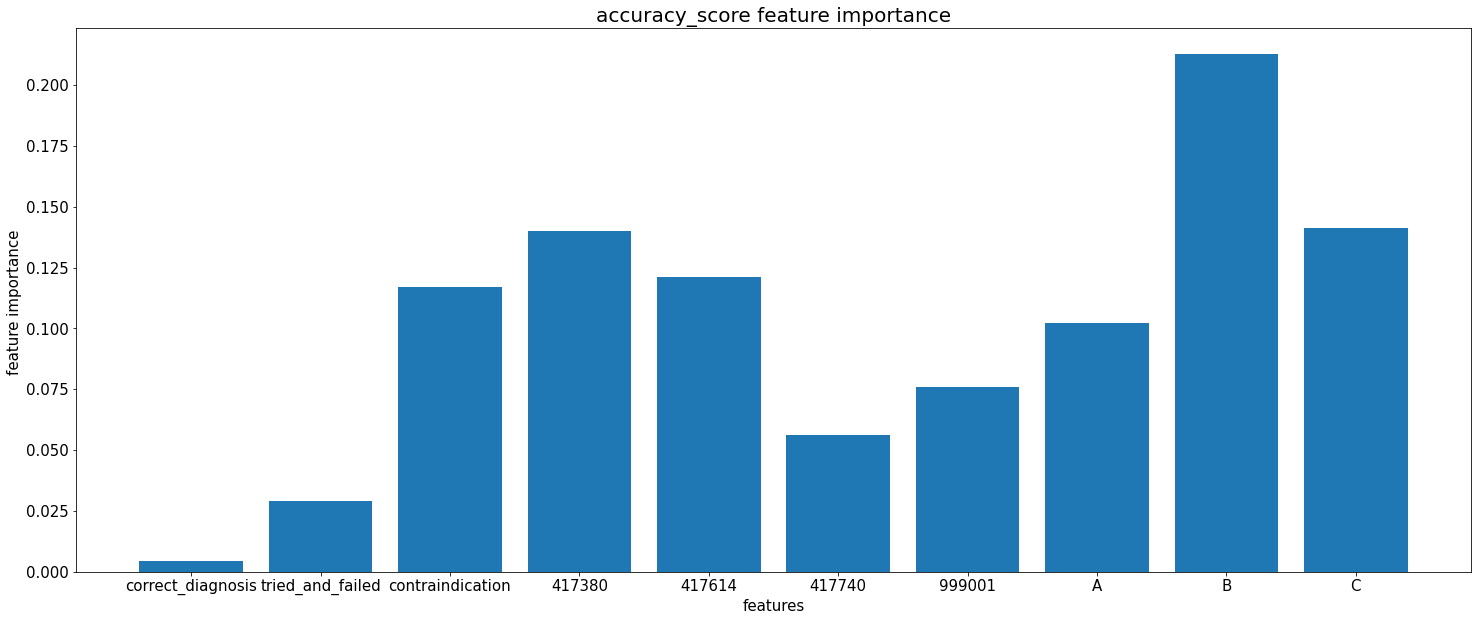



-precision feature importance-

correct_diagnosis : 0.009
tried_and_failed : 0.031
contraindication : 0.122
417380 : 0.302
417614 : 0.047
417740 : 0.109
999001 : 0.03
A : 0.086
B : 0.214
C : 0.05


double click the image to zoom in and out


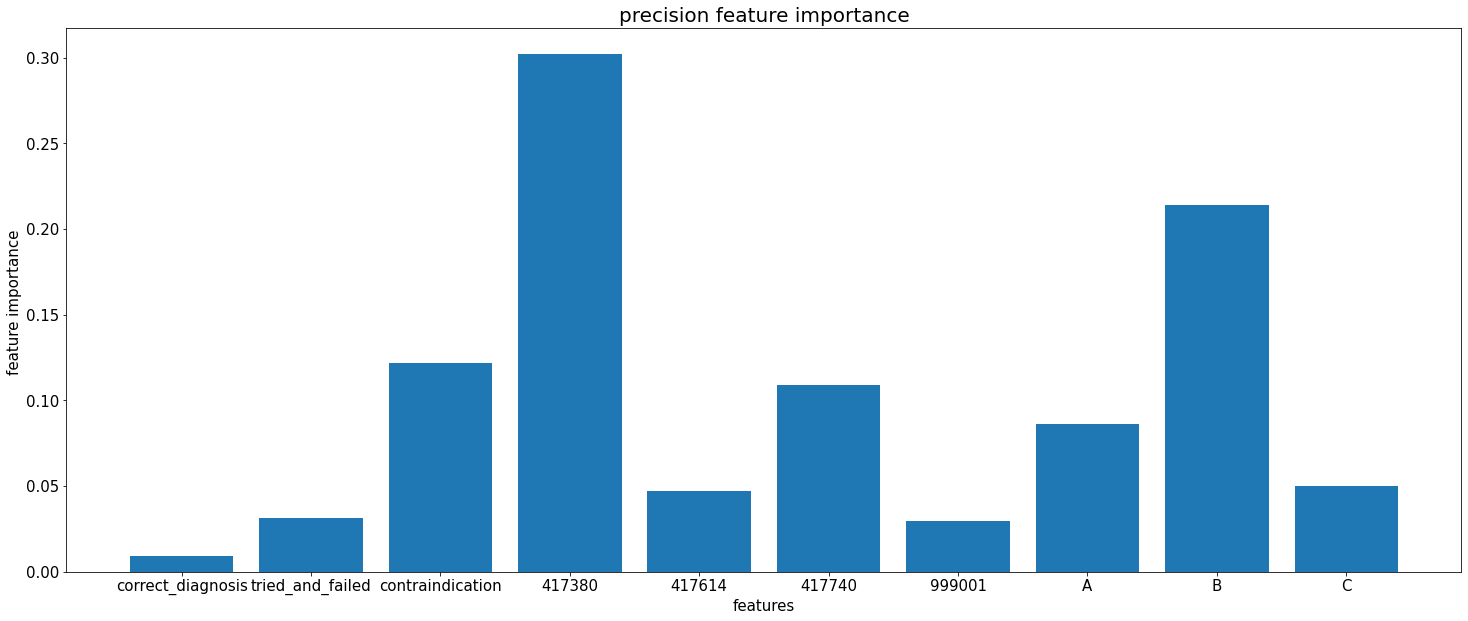



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.075
contraindication : 0.27
417380 : 0.09
417614 : 0.0
417740 : 0.067
999001 : 0.078
A : 0.088
B : 0.232
C : 0.099


double click the image to zoom in and out


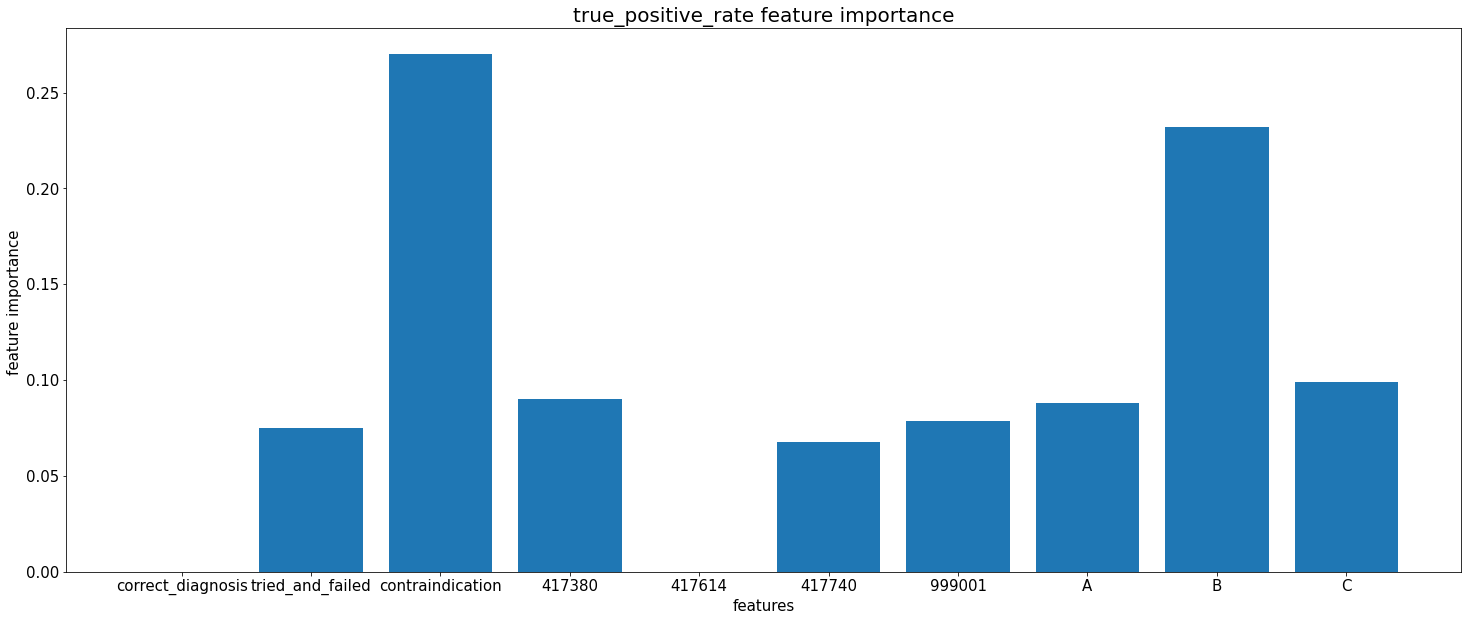



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.075
contraindication : 0.27
417380 : 0.09
417614 : 0.0
417740 : 0.067
999001 : 0.078
A : 0.088
B : 0.232
C : 0.099


double click the image to zoom in and out


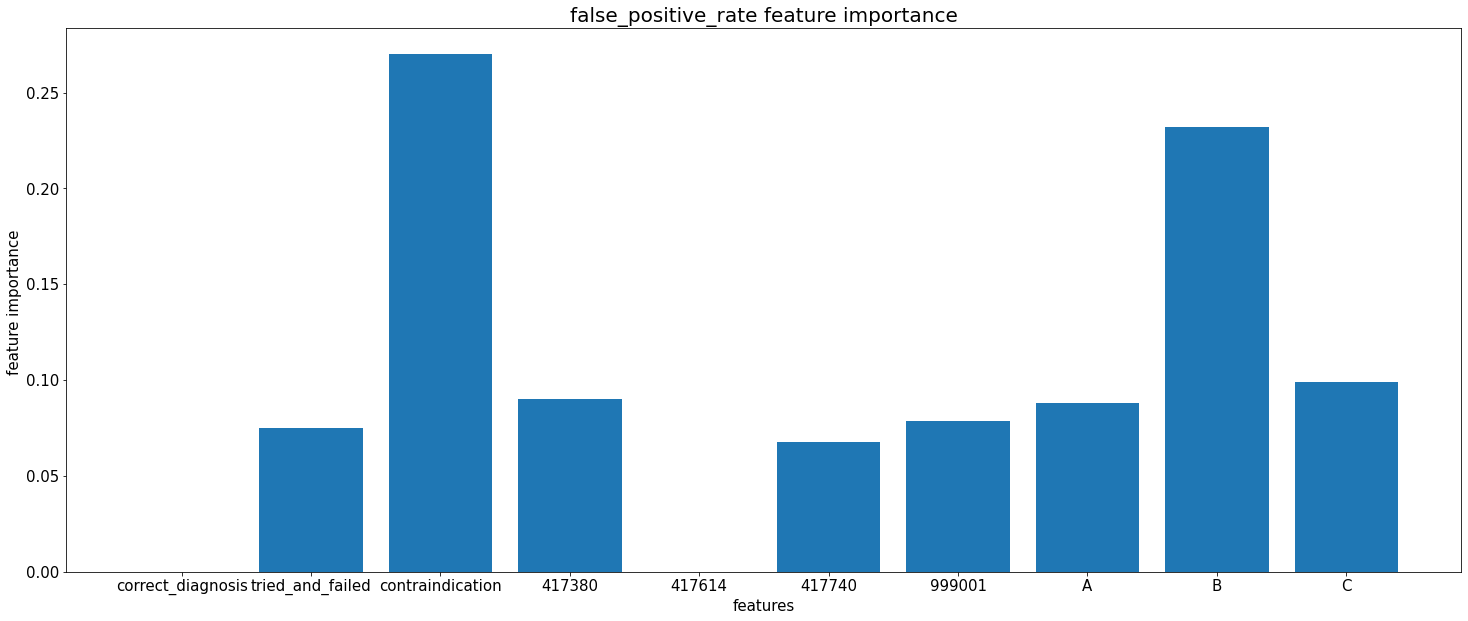



-f1 feature importance-

correct_diagnosis : 0.008
tried_and_failed : 0.034
contraindication : 0.074
417380 : 0.156
417614 : 0.202
417740 : 0.107
999001 : 0.056
A : 0.1
B : 0.161
C : 0.103


double click the image to zoom in and out


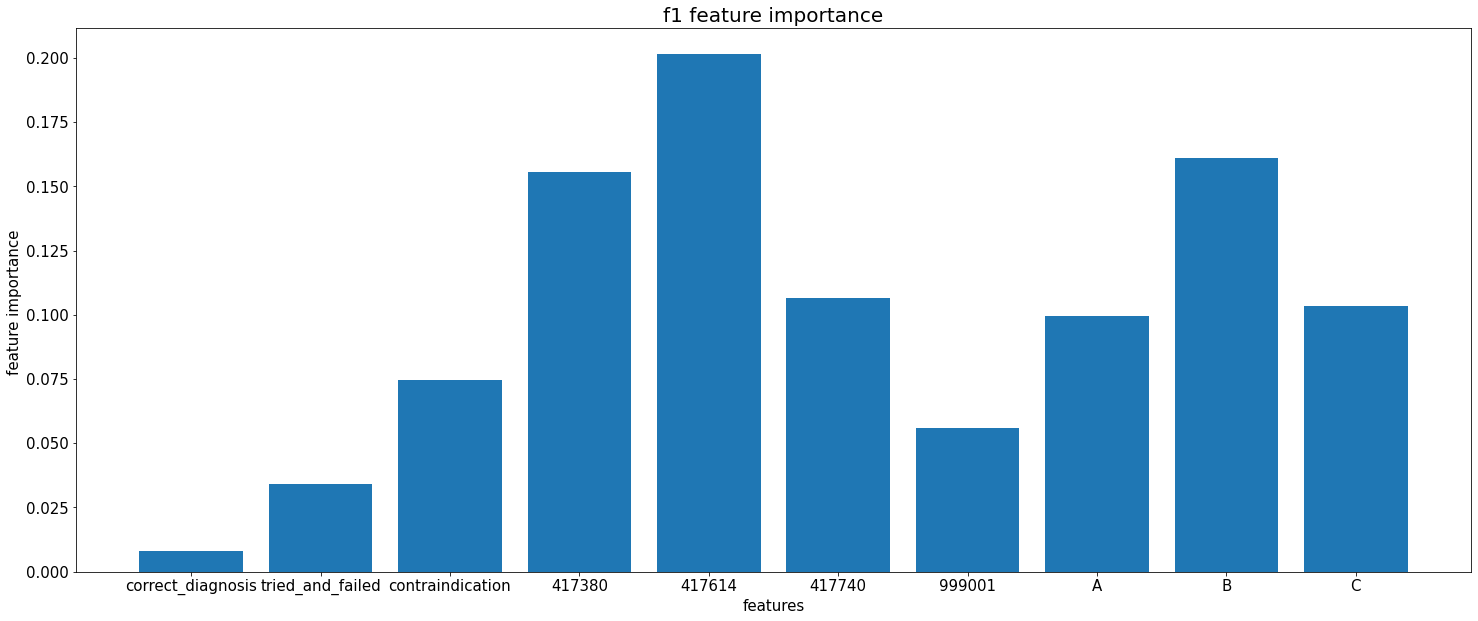



-roc_auc feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.021
contraindication : 0.065
417380 : 0.18
417614 : 0.141
417740 : 0.131
999001 : 0.05
A : 0.102
B : 0.246
C : 0.062


double click the image to zoom in and out


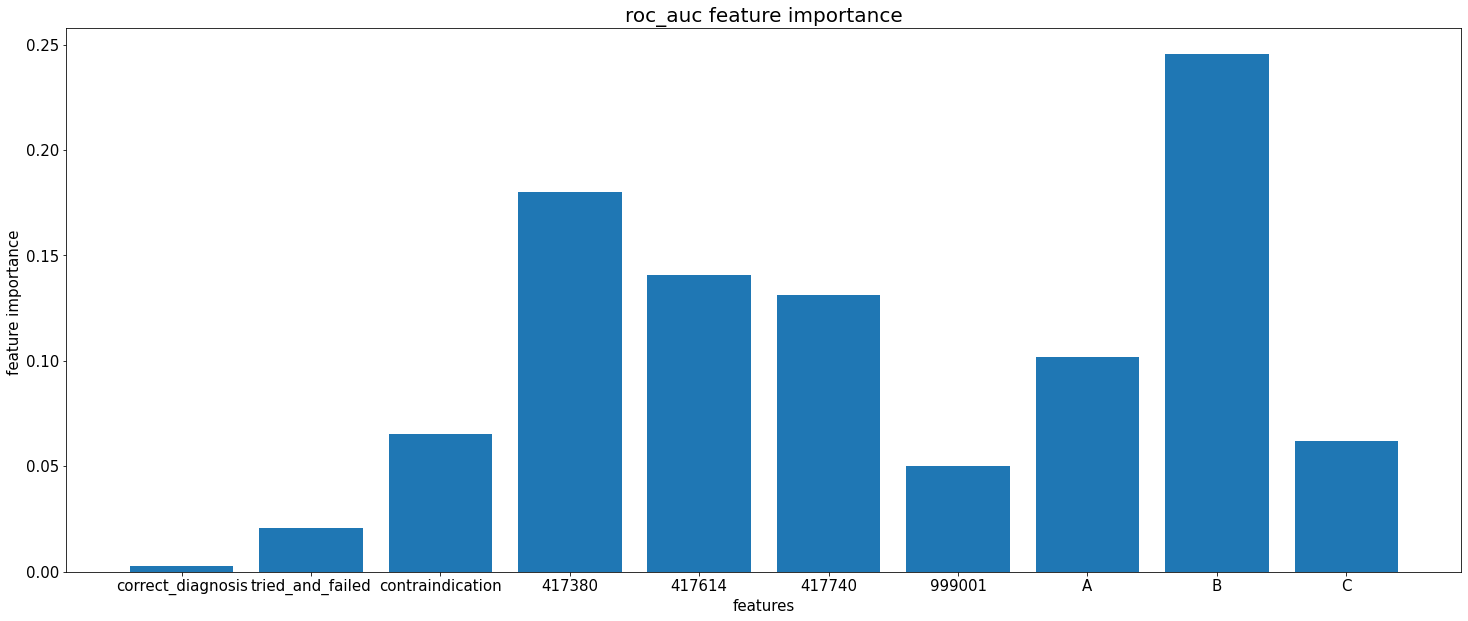

In [48]:
# summarize accuracy_score feature importance
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(X_train.columns[i],':',round(acs_importance[i]/5,3))
# plot accuracy_score feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), acs_importance/5)
plt.show()  


print()
print()


# summarize precision feature importance
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(X_train.columns[i],':',round(pre_importance[i]/5,3))
# plot precision feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), pre_importance/5)
plt.show()    


print()
print()


# summarize true_positive_rate feature importance    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(X_train.columns[i],':',round(tpr_importance[i]/5,3))
# plot true_positive_rate feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), tpr_importance/5)
plt.show()    


print()
print()


# summarize false_positive_rate feature importance 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(X_train.columns[i],':',round(fpr_importance[i]/5,3))
# plot false_positive_rate feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), fpr_importance/5)
plt.show()    


print()
print()


# summarize f1 feature importance   
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(X_train.columns[i],':',round(f1_importance[i]/5,3))
# plot f1 feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), f1_importance/5)
plt.show()    


print()
print()


# summarize roc_auc feature importance
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(X_train.columns[i],':',round(auc_importance[i]/5,3))
# plot roc_auc feature importance
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(X_test.columns[:10].astype(str), auc_importance/5)
plt.show()    

In [49]:
X_train.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C',           '417380A',           '417380B',
                 '417380C',           '417614A',           '417614B',
                 '417614C',           '417740A',           '417740B',
                 '417740C',           '999001A',           '999001B',
                 '999001C'],
      dtype='object')

In [50]:
# accuracy_score
acs_importance[3] = max(acs_importance[3:7])
acs_importance[4] = max(acs_importance[7:])
acs_importance = acs_importance[:5]
# precision
pre_importance[3] = max(pre_importance[3:7])
pre_importance[4] = max(pre_importance[7:])
pre_importance = pre_importance[:5]
# true_positive_rate
tpr_importance[3] = max(tpr_importance[3:7])
tpr_importance[4] = max(tpr_importance[7:])
tpr_importance = tpr_importance[:5]
# false_positive_rate
fpr_importance[3] = max(fpr_importance[3:7])
fpr_importance[4] = max(fpr_importance[7:])
fpr_importance = fpr_importance[:5]
# f1
f1_importance[3] = max(f1_importance[3:7])
f1_importance[4] = max(f1_importance[7:])
f1_importance = f1_importance[:5]
# roc_auc
auc_importance[3] = max(auc_importance[3:7])
auc_importance[4] = max(auc_importance[7:])
auc_importance = auc_importance[:5]

In [51]:
features = list(X_train.columns.copy())
features[3] = 'bin'
features[4] = 'drug'
features = features[:5]
features

['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin', 'drug']

-accuracy_score feature importance-

correct_diagnosis : 0.004
tried_and_failed : 0.029
contraindication : 0.117
bin : 0.14
drug : 0.213


double click the image to zoom in and out


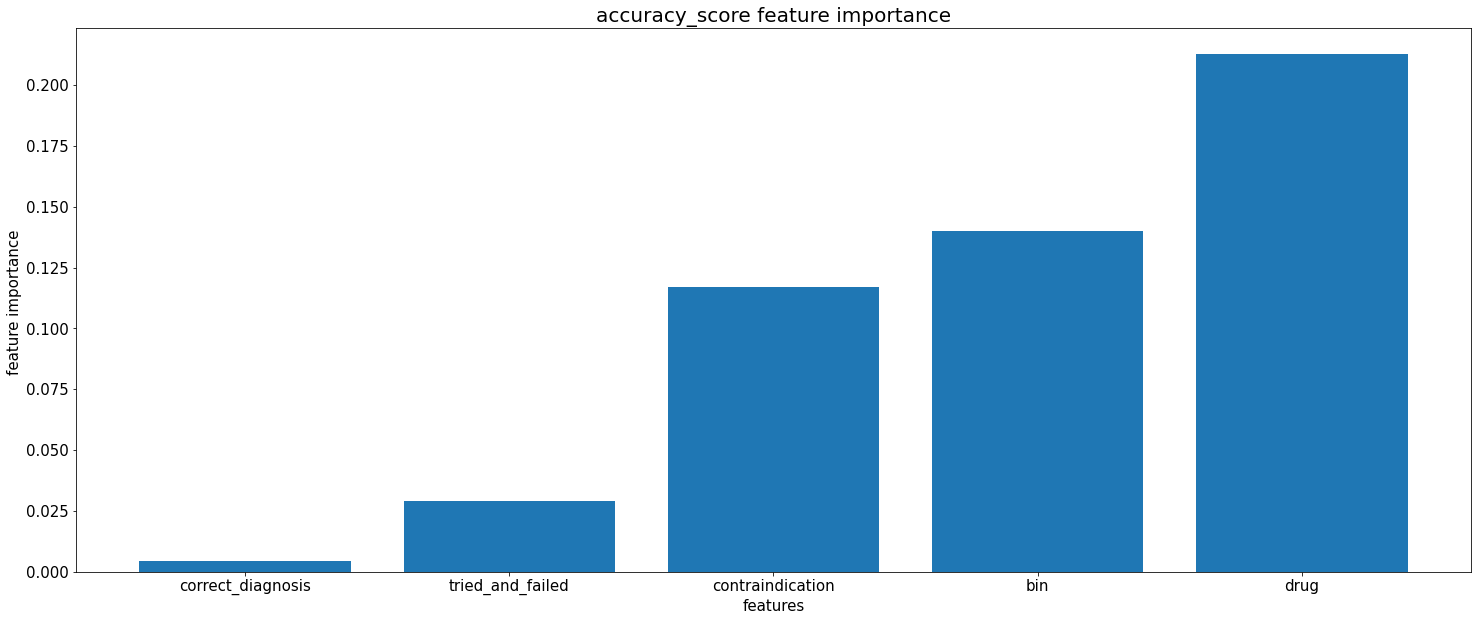



-precision feature importance-

correct_diagnosis : 0.009
tried_and_failed : 0.031
contraindication : 0.122
bin : 0.302
drug : 0.214


double click the image to zoom in and out


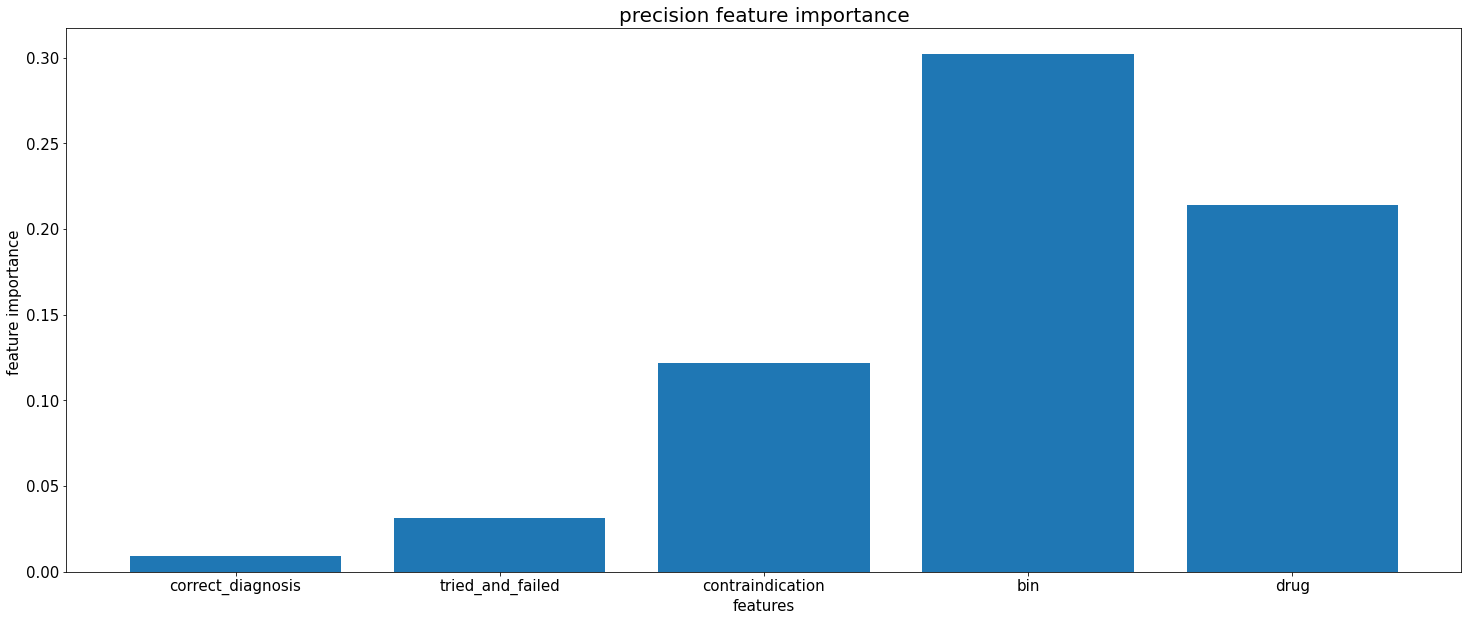



-true_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.075
contraindication : 0.27
bin : 0.09
drug : 0.232


double click the image to zoom in and out


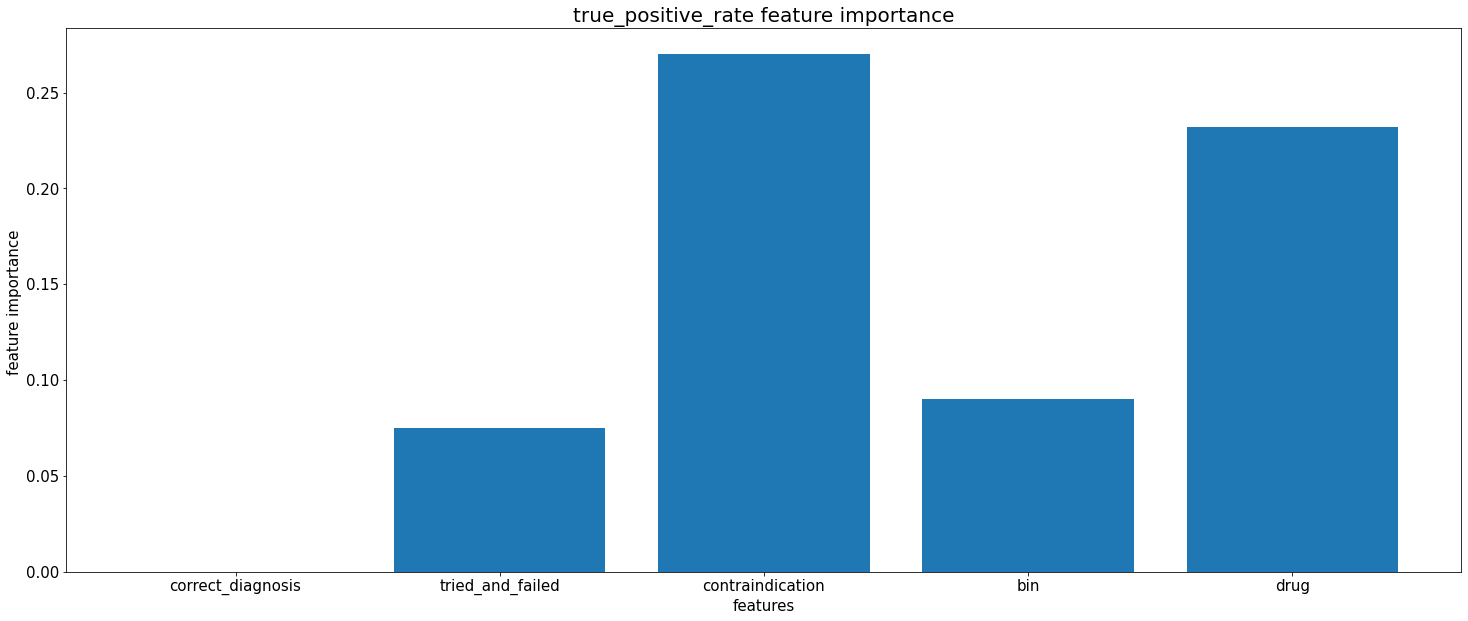



-false_positive_rate feature importance-

correct_diagnosis : 0.0
tried_and_failed : 0.075
contraindication : 0.27
bin : 0.09
drug : 0.232


double click the image to zoom in and out


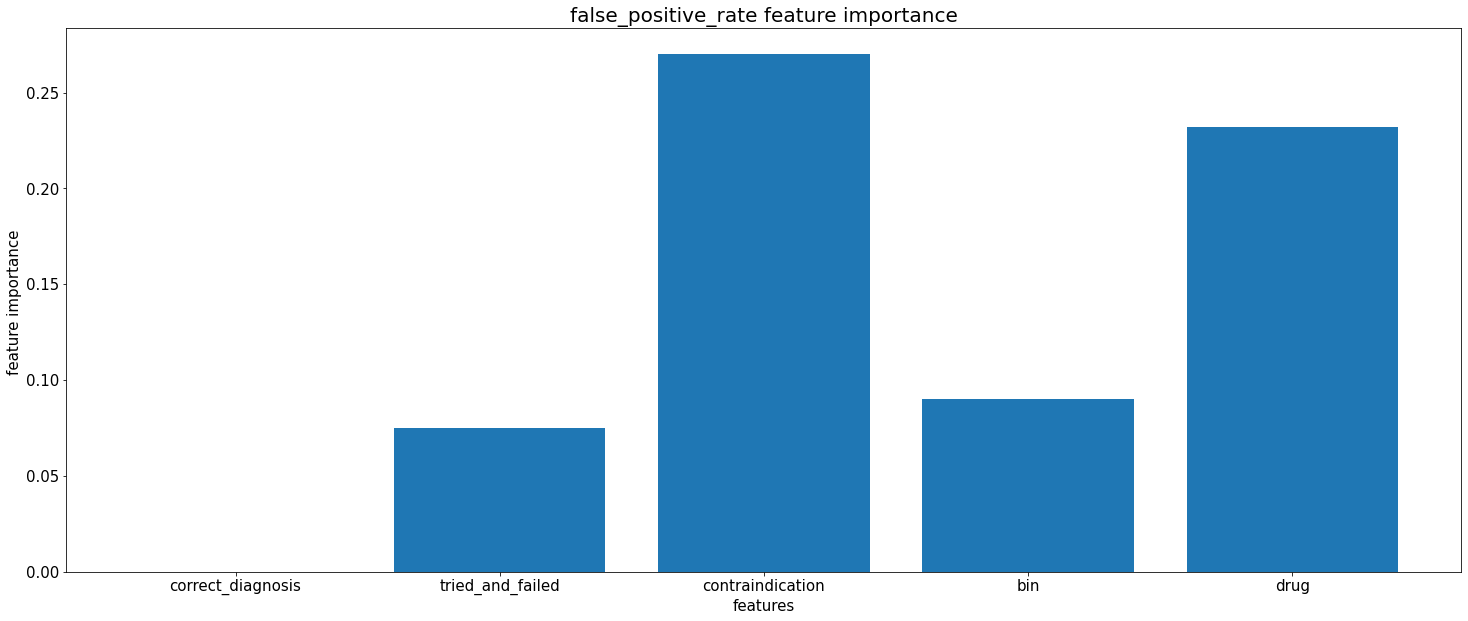



-f1 feature importance-

correct_diagnosis : 0.008
tried_and_failed : 0.034
contraindication : 0.074
bin : 0.202
drug : 0.161


double click the image to zoom in and out


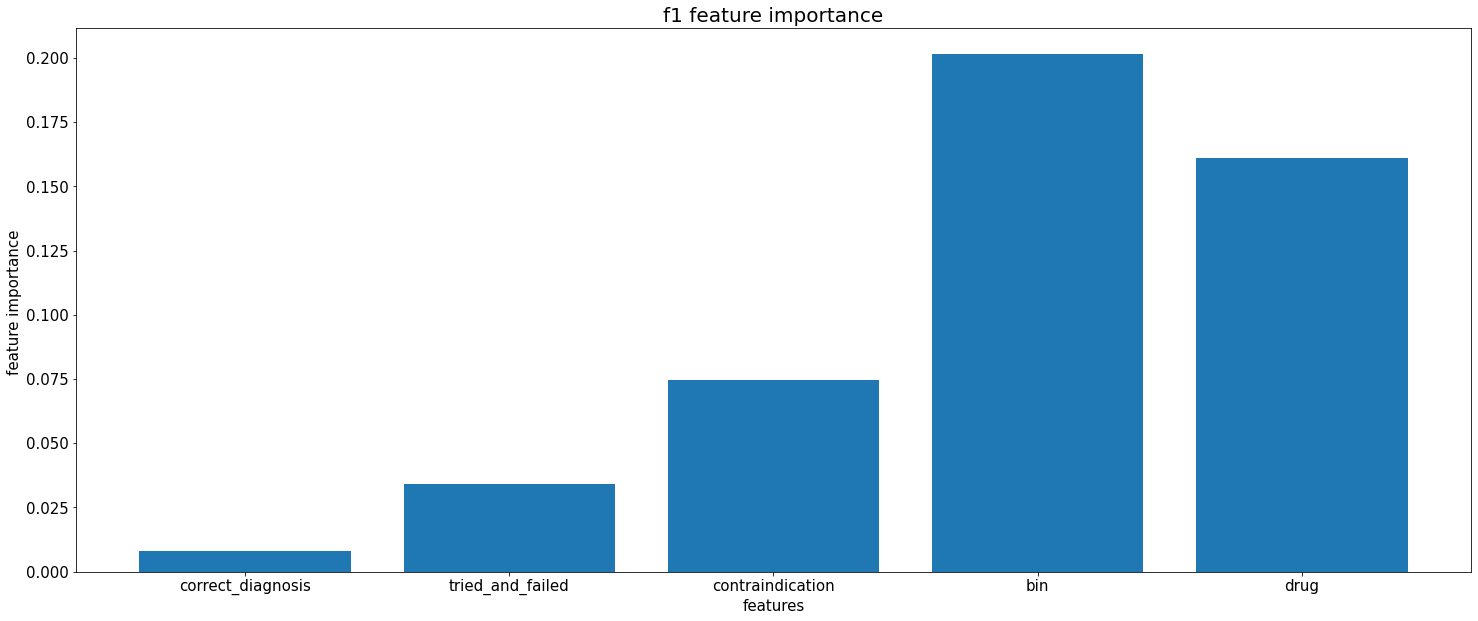



-roc_auc feature importance-

correct_diagnosis : 0.003
tried_and_failed : 0.021
contraindication : 0.065
bin : 0.18
drug : 0.246


double click the image to zoom in and out


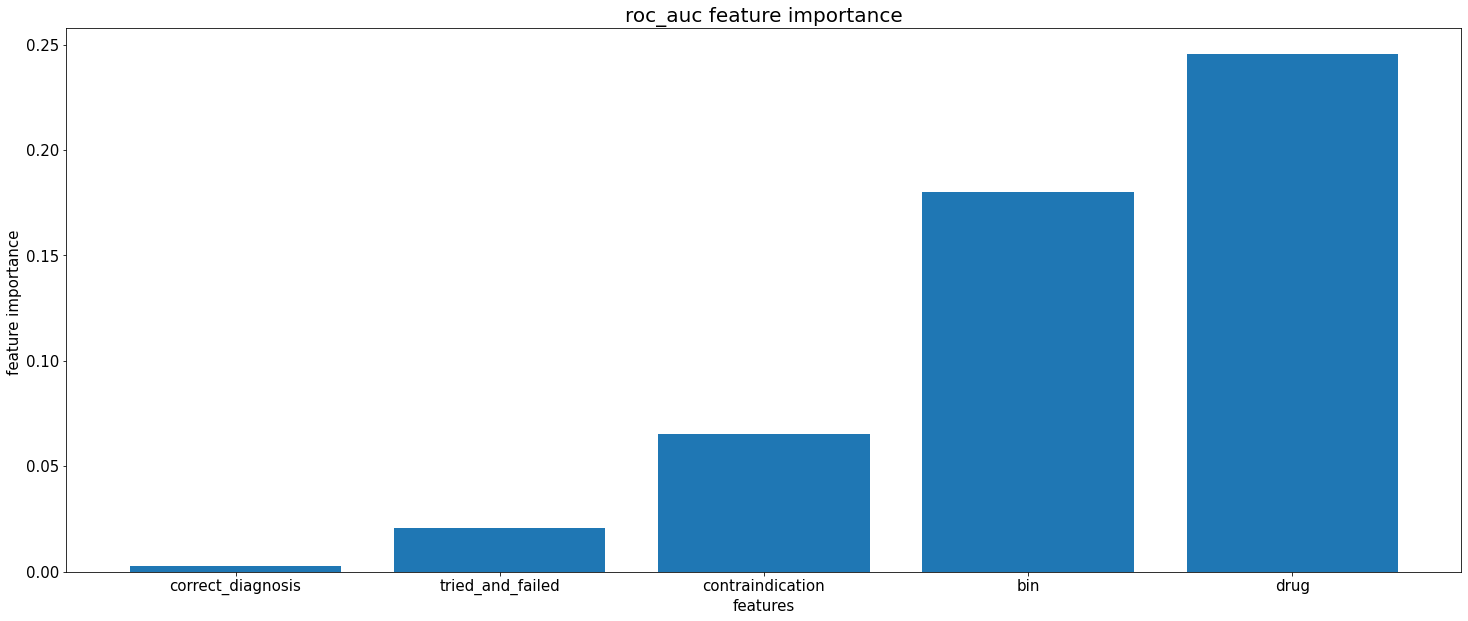

In [52]:
#summarize feature importances with respect to the accuracy_score
print('\033[1m'+'-accuracy_score feature importance-')
print('\033[0m')
for i in range(len(acs_importance)):
        print(features[i],':',round(acs_importance[i]/5,3))
# plot feature importances with respect to the accuracy_score
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('accuracy_score feature importance', fontsize = 20)
plt.bar(features, acs_importance/5)
plt.show()  


print()
print()


#summarize feature importances with respect to the precision
print('\033[1m'+'-precision feature importance-')
print('\033[0m')
for i in range(len(pre_importance)):
        print(features[i],':',round(pre_importance[i]/5,3))
# plot feature importances with respect to the precision
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('precision feature importance', fontsize = 20)
plt.bar(features, pre_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the true_positive_rate feature    
print('\033[1m'+'-true_positive_rate feature importance-')
print('\033[0m')
for i in range(len(tpr_importance)):
        print(features[i],':',round(tpr_importance[i]/5,3))
# plot feature importances with respect to the true_positive_rate feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('true_positive_rate feature importance', fontsize = 20)
plt.bar(features, tpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the false_positive_rate feature 
print('\033[1m'+'-false_positive_rate feature importance-')
print('\033[0m')
for i in range(len(fpr_importance)):
        print(features[i],':',round(fpr_importance[i]/5,3))
# plot feature importances with respect to the false_positive_rate feature
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('false_positive_rate feature importance', fontsize = 20)
plt.bar(features, fpr_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the f1    
print('\033[1m'+'-f1 feature importance-')
print('\033[0m')
for i in range(len(f1_importance)):
        print(features[i],':',round(f1_importance[i]/5,3))
# plot feature importances with respect to the f1 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('f1 feature importance', fontsize = 20)
plt.bar(features, f1_importance/5)
plt.show()    


print()
print()


#summarize feature importances with respect to the roc_auc 
print('\033[1m'+'-roc_auc feature importance-')
print('\033[0m')
for i in range(len(auc_importance)):
        print(features[i],':',round(auc_importance[i]/5,3))
# plot feature importances with respect to the roc_auc 
print()
print()
print('double click the image to zoom in and out')
plt.figure(figsize = (25,10))
plt.xlabel('features', fontsize = 15)
plt.ylabel('feature importance ', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('roc_auc feature importance', fontsize = 20)
plt.bar(features, auc_importance/5)
plt.show()

In [53]:
# key performance indicators
kpis.loc['XGB','accuracy_score'] = round(np.mean(acses),3)
kpis.loc['XGB','precision'] = round(np.mean(pres),3)
kpis.loc['XGB','true_positive_rate'] = round(np.mean(tprs),3)
kpis.loc['XGB','false_positive_rate'] = round(np.mean(fprs),3)
kpis.loc['XGB','f1'] = round(np.mean(f1s),3)
kpis.loc['XGB','roc_auc'] = round(np.mean(aucs),3)

In [54]:
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.814,0.834,0.932,0.512,0.880,0.878
DT,0.814,0.834,1.000,1.000,0.881,0.878
XGB,0.814,0.835,0.965,0.697,0.881,0.878


### -Key Performance Indicators-

We compare key performance indicators calculated on the test data with those that were calculated on the training data.

In [55]:
# kpis calculated on the test data
kpis

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.814,0.834,0.932,0.512,0.880,0.878
DT,0.814,0.834,1.000,1.000,0.881,0.878
XGB,0.814,0.835,0.965,0.697,0.881,0.878


In [56]:
# kpis that were calculated on the training data
pd.read_csv('data/kpis_train', index_col = 0).loc[['Log','DT','XGB']]

,accuracy_score,precision,true_positive_rate,false_positive_rate,f1,roc_auc
Log,0.815,0.832,0.938,0.524,0.882,0.879
DT,0.815,0.838,1.000,1.000,0.879,0.879
XGB,0.815,0.846,0.969,0.715,0.881,0.879


## 3. Bias-Variance Tradeoff

- Out of X_train and y_train, we sample by bootsrapping with the sample size equal to the sizes of X_train and y_train 200 times.
- We train the models(logistic regression, decision tree and xgboost) against the sampled data.
- We evaluate the trained models against X_test and y_test with repspect to the '0-1_loss' score.
- We calculate the bias-variance decomposition using the above calculations.

In [57]:
# the bias and the variance for the logistic regression model
from mlxtend.evaluate import bias_variance_decomp

loss, bias, var = bias_variance_decomp(log_reg, 
                                      X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
                                      loss='0-1_loss', num_rounds=200, random_seed=1)
# summarize results
print('-Logistic Regression-')
print('0-1_loss: %.3f' % loss)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)
print()
print()

# the bias and the variance for the decision tree model
loss, bias, var = bias_variance_decomp(dt, 
                                      X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
                                      loss='0-1_loss', num_rounds=200, random_seed=1)
# summarize results
print('-Decision Tree-')
print('0-1_loss: %.3f' % loss)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)
print()
print()

# the bias and the variance for the XGboost model
loss, bias, var = bias_variance_decomp(xgb, 
                                      X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
                                      loss='0-1_loss', num_rounds=200, random_seed=1)
# summarize results
print('XGBoost')
print('0-1_loss: %.3f' % loss)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

-Logistic Regression-
0-1_loss: 0.185
Bias: 0.185
Variance: 0.001


-Decision Tree-
0-1_loss: 0.186
Bias: 0.185
Variance: 0.022


XGBoost
0-1_loss: 0.186
Bias: 0.185
Variance: 0.020


- Biases of all three models are the same.
- Logistic regression has the lowest variance.
- This result further justifies our choice of logistic regression.

## 4. Confidence Intervals via Bootstrapping

- We train the models(logistic regression, decision tree and xgboost) against the sampled data.
- Out of X_test and y_test, we sample by bootsrapping with the sample size equal to the sizes of X_test and y_test 200 times.
- We evaluate the trained models against sampled data with repspect to the '0-1_loss' score.
- We calculate the bias-variance decomposition using the above calculations.
- Note that we are bootstrapping the test data set whereas when calculating bias-variance decomposition we bootstrapped from the training data set.

In [58]:
from sklearn.utils import resample

In [59]:
# the number of resampling
n_bootstrap = 5
# key performance indicators via bootstrapping
log_reg_scores = np.empty((n_bootstrap, len(kpis.columns)))
dt_scores = np.empty((n_bootstrap, len(kpis.columns)))
xgb_scores = np.empty((n_bootstrap, len(kpis.columns)))

In [60]:
paras.loc['Log', :] 

accuracy_score         {'penalty': 'none', 'C': 0.01}
precision                {'penalty': 'l2', 'C': 0.01}
true_positive_rate       {'penalty': 'l2', 'C': 0.01}
false_positive_rate      {'penalty': 'l2', 'C': 0.01}
f1                       {'penalty': 'l2', 'C': 0.01}
roc_auc                  {'penalty': 'l2', 'C': 0.01}
Name: Log, dtype: object

In [61]:
# fit the models against training data 

# accuracy_score
log_reg0 = LogisticRegression(penalty = paras.loc['Log','accuracy_score']['penalty'], 
                              C=paras.loc['Log','accuracy_score']['C'],   
                              max_iter = 100)
dt0 = DecisionTreeClassifier(max_depth = paras.loc['DT','accuracy_score']['max_depth'])
xgb0 = XGBClassifier(learning_rate = paras.loc['XGB','accuracy_score']['learning_rate'],
                     max_depth = paras.loc['XGB','accuracy_score']['max_depth'],
                     use_label_encoder=False,
                     n_estimators = 100,
                     random_state = 623,
                     eval_metric = 'logloss')

log_reg0.fit(X_train.values, y_train.values)
dt0.fit(X_train.iloc[:,:10].values, y_train.values) 
xgb0.fit(X_train.iloc[:,:10].values, y_train.values) 

# precision
log_reg1 = LogisticRegression(penalty = paras.loc['Log','precision']['penalty'], 
                              C=paras.loc['Log','precision']['C'],
                              max_iter = 100)
dt1 = DecisionTreeClassifier(max_depth = paras.loc['DT','precision']['max_depth'])
xgb1 = XGBClassifier(learning_rate = paras.loc['XGB','precision']['learning_rate'],
                     max_depth = paras.loc['XGB','precision']['max_depth'],
                     use_label_encoder=False,
                     n_estimators = 100,
                     random_state = 623,
                     eval_metric = 'logloss')

log_reg1.fit(X_train.values, y_train.values)
dt1.fit(X_train.iloc[:,:10].values, y_train.values)
xgb1.fit(X_train.iloc[:,:10].values, y_train.values)

# true_positive_value
log_reg2 = LogisticRegression(penalty = paras.loc['Log','true_positive_rate']['penalty'], 
                                 C=paras.loc['Log','true_positive_rate']['C'],
                                 max_iter = 100, 
                                 l1_ratio = .5)
dt2 = DecisionTreeClassifier(max_depth = paras.loc['DT','true_positive_rate']['max_depth'])
xgb2 = XGBClassifier(learning_rate = paras.loc['XGB','true_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','true_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')

log_reg2.fit(X_train.values, y_train.values)
dt2.fit(X_train.iloc[:,:10].values, y_train.values)
xgb2.fit(X_train.iloc[:,:10].values, y_train.values)

# false_positive_value
log_reg3 = LogisticRegression(penalty = paras.loc['Log','false_positive_rate']['penalty'], 
                              C=paras.loc['Log','false_positive_rate']['C'],
                              max_iter = 100, 
                              l1_ratio = .5)
dt3 = DecisionTreeClassifier(max_depth = paras.loc['DT','false_positive_rate']['max_depth'])
xgb3 = XGBClassifier(learning_rate = paras.loc['XGB','false_positive_rate']['learning_rate'],
                    max_depth = paras.loc['XGB','false_positive_rate']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')

log_reg3.fit(X_train.values, y_train.values)
dt3.fit(X_train.iloc[:,:10].values, y_train.values)
xgb3.fit(X_train.iloc[:,:10].values, y_train.values)
        
# f1
log_reg4 = LogisticRegression(penalty = paras.loc['Log','f1']['penalty'], 
                              C=paras.loc['Log','f1']['C'],
                              max_iter = 100)
dt4 = DecisionTreeClassifier(max_depth = paras.loc['DT','f1']['max_depth'])
xgb4 = XGBClassifier(learning_rate = paras.loc['XGB','f1']['learning_rate'],
                    max_depth = paras.loc['XGB','f1']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')

log_reg4.fit(X_train.values, y_train.values)
dt4.fit(X_train.iloc[:,:10].values, y_train.values)
xgb4.fit(X_train.iloc[:,:10].values, y_train.values)
    
# roc_auc
log_reg5 = LogisticRegression(penalty = paras.loc['Log','roc_auc']['penalty'], 
                              C=paras.loc['Log','roc_auc']['C'], 
                              max_iter = 100)
dt5 = DecisionTreeClassifier(max_depth = paras.loc['DT','roc_auc']['max_depth'])
xgb5 = XGBClassifier(learning_rate = paras.loc['XGB','roc_auc']['learning_rate'],
                    max_depth = paras.loc['XGB','roc_auc']['max_depth'],
                    use_label_encoder=False,
                    n_estimators = 100,
                    random_state = 623,
                    eval_metric = 'logloss')

log_reg5.fit(X_train.values, y_train.values)
dt5.fit(X_train.iloc[:,:10].values, y_train.values)
xgb5.fit(X_train.iloc[:,:10].values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=623,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [62]:
# bootstrapping computing key performance indicators
for i in range(n_bootstrap):
    X_boot, y_boot=resample(X_test, y_test, 
                            replace=True,
                            random_state=i)
    X_boot = pd.DataFrame(data = X_boot, columns = X.columns)
    y_boot = pd.DataFrame(data = y_boot)
    
    # accuracy_score
    pred = log_reg0.predict(X_boot.values)
    log_reg_scores[i,0] = accuracy_score(y_boot.values, pred)
    
    pred = dt0.predict(X_boot.iloc[:,:10].values)
    dt_scores[i,0] = accuracy_score(y_boot.values, pred)
        
    pred = xgb0.predict(X_boot.iloc[:,:10].values)
    xgb_scores[i,0] = accuracy_score(y_boot.values, pred)
    
    # precision
    pred = log_reg1.predict(X_boot.values)
    log_reg_scores[i,1] = precision_score(y_boot, pred)
    
    pred = dt1.predict(X_boot.iloc[:,:10].values)
    dt_scores[i,1] = precision_score(y_boot, pred)
    
    pred = xgb1.predict(X_boot.iloc[:,:10].values)
    xgb_scores[i,1] = precision_score(y_boot, pred)
    
    # true_positive_rate
    pred = log_reg2.predict(X_boot.values)
    conf_mat = confusion_matrix(y_boot, pred)
    log_reg_scores[i,2] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    pred = dt2.predict(X_boot.iloc[:,:10].values)
    conf_mat = confusion_matrix(y_boot, pred)
    dt_scores[i,2] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    pred = xgb2.predict(X_boot.iloc[:,:10].values)
    conf_mat = confusion_matrix(y_boot, pred)
    xgb_scores[i,2] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    
    # false_positive_rate
    pred = log_reg3.predict(X_boot.values)
    conf_mat = confusion_matrix(y_boot, pred)
    log_reg_scores[i,3] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
        
    pred = dt3.predict(X_boot.iloc[:,:10].values)
    conf_mat = confusion_matrix(y_boot, pred)
    dt_scores[i,3] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    pred = xgb3.predict(X_boot.iloc[:,:10].values)
    conf_mat = confusion_matrix(y_boot, pred)
    xgb_scores[i,3] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    
    # f1
    pred = log_reg4.predict(X_boot.values)
    log_reg_scores[i,4] = f1_score(y_boot, pred)

    pred = dt4.predict(X_boot.iloc[:,:10].values)
    dt_scores[i,4] = f1_score(y_boot, pred)
    
    pred = xgb4.predict(X_boot.iloc[:,:10].values)
    xgb_scores[i,4] = f1_score(y_boot, pred)
    
    # roc_auc
    pred_proba = log_reg5.predict_proba(X_boot.values)[:,1]
    log_reg_scores[i,5] = roc_auc_score(y_boot, pred_proba)
    
    pred_proba = dt5.predict_proba(X_boot.iloc[:,:10].values)[:,1]
    dt_scores[i,5] = roc_auc_score(y_boot, pred_proba)
    
    pred_proba = xgb5.predict_proba(X_boot.iloc[:,:10].values)[:,1]
    xgb_scores[i,5] = roc_auc_score(y_boot, pred_proba)

0 . accuracy_score


Logistic Regression
confidence interval : [ 0.8144 , 0.8167 ]
length :  0.0022


Decision Tree
confidence interval : [ 0.8142 , 0.8167 ]
length :  0.0024


XGBoost
confidence interval(xgboost) : [ 0.8142 , 0.8167 ]
length :  0.0024


<Figure size 1440x720 with 0 Axes>

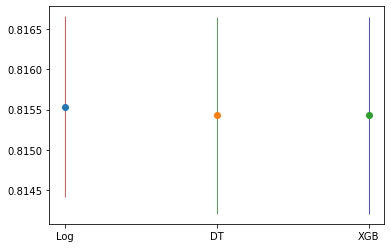

1 . precision


Logistic Regression
confidence interval : [ 0.8345 , 0.8378 ]
length :  0.0033


Decision Tree
confidence interval : [ 0.8346 , 0.838 ]
length :  0.0033


XGBoost
confidence interval(xgboost) : [ 0.8476 , 0.8508 ]
length :  0.0032


<Figure size 1440x720 with 0 Axes>

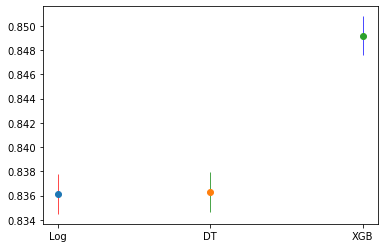

2 . true_positive_rate


Logistic Regression
confidence interval : [ 0.9311 , 0.9323 ]
length :  0.0013


Decision Tree
confidence interval : [ 1.0 , 1.0 ]
length :  0.0


XGBoost
confidence interval(xgboost) : [ 0.9703 , 0.9708 ]
length :  0.0005


<Figure size 1440x720 with 0 Axes>

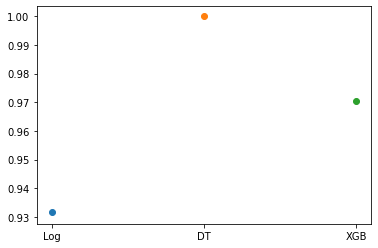

3 . false_positive_rate


Logistic Regression
confidence interval : [ 0.5043 , 0.5095 ]
length :  0.0051


Decision Tree
confidence interval : [ 1.0 , 1.0 ]
length :  0.0


XGBoost
confidence interval(xgboost) : [ 0.7145 , 0.7182 ]
length :  0.0037


<Figure size 1440x720 with 0 Axes>

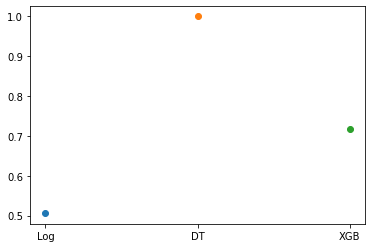

4 . f1


Logistic Regression
confidence interval : [ 0.8805 , 0.8821 ]
length :  0.0016


Decision Tree
confidence interval : [ 0.8809 , 0.8826 ]
length :  0.0018


XGBoost
confidence interval(xgboost) : [ 0.8809 , 0.8826 ]
length :  0.0017


<Figure size 1440x720 with 0 Axes>

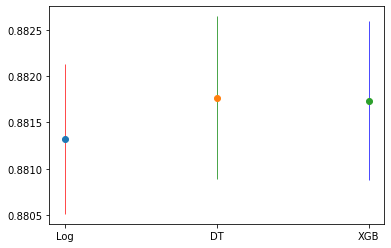

5 . roc_auc


Logistic Regression
confidence interval : [ 0.8776 , 0.8793 ]
length :  0.0017


Decision Tree
confidence interval : [ 0.8778 , 0.8796 ]
length :  0.0018


XGBoost
confidence interval(xgboost) : [ 0.8778 , 0.8796 ]
length :  0.0018


<Figure size 1440x720 with 0 Axes>

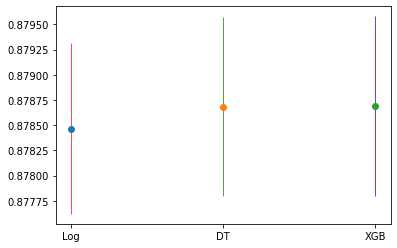

In [63]:
# confidence intervals
log_reg_ci = 1.96 * np.std(log_reg_scores, axis = 0)/np.sqrt(n_bootstrap)
dt_ci = 1.96 * np.std(dt_scores, axis = 0)/np.sqrt(n_bootstrap)
xgb_ci = 1.96 * np.std(xgb_scores, axis = 0)/np.sqrt(n_bootstrap)

for i in range(len(kpis.columns)) : 
    print(i,'.',kpis.columns[i])
    print()
    print()
    plt.figure(figsize = (20,10))
    fig, ax = plt.subplots()
    # logistic regression
    print('Logistic Regression')
    print('confidence interval : [', round(np.mean(log_reg_scores[:,i], axis = 0) - log_reg_ci[i],4),',', round(np.mean(log_reg_scores[:,i], axis = 0) + log_reg_ci[i],4),']' )
    print('length : ', round(2*log_reg_ci[i],4))
    ax.plot(['Log'], np.mean(log_reg_scores[:,i]), 'o')
    ax.fill_between(['Log'], 
                    (np.mean(log_reg_scores[:,i], axis = 0) - log_reg_ci[i]), 
                    (np.mean(log_reg_scores[:,i], axis = 0) + log_reg_ci[i]), 
                    color='r', 
                    alpha=.7)
    print()
    print()
    # decision tree
    print('Decision Tree')
    print('confidence interval : [', round(np.mean(dt_scores[:,i], axis = 0) - dt_ci[i],4),',', round(np.mean(dt_scores[:,i], axis = 0) + dt_ci[i],4),']' )
    print('length : ', round(2*dt_ci[i],4))
    ax.plot(['DT'], np.mean(dt_scores[:,i]), 'o')
    ax.fill_between(['DT'], 
                    (np.mean(dt_scores[:,i], axis = 0) - dt_ci[i]), 
                    (np.mean(dt_scores[:,i], axis = 0) + dt_ci[i]), 
                    color='g', 
                    alpha=.7)
    ax.plot(['XGB'], np.mean(xgb_scores[:,i]), 'o')
    print()
    print()
    # xgboost
    print('XGBoost')
    print('confidence interval(xgboost) : [', round(np.mean(xgb_scores[:,i], axis = 0) - xgb_ci[i],4),',', round(np.mean(xgb_scores[:,i], axis = 0) + xgb_ci[i],4),']' )
    print('length : ', round(2*xgb_ci[i],4))
    ax.fill_between(['XGB'], 
                    (np.mean(xgb_scores[:,i], axis = 0) - xgb_ci[i]), 
                    (np.mean(xgb_scores[:,i], axis = 0) + xgb_ci[i]), 
                    color='b', 
                    alpha=.7)
    plt.show()

- Confidence intervals of all three models are almost the same.
- In term of confidence interval, no model is supeior over another.